In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
from datetime import datetime, timedelta

from qfin.assets import *
from qfin.models import BlackScholesModel, HestonModel, VarianceGammaModel, SVJModel, SVCJModel, CGMYModel, MertonModel, KDEModel
from qfin.hedges import *
from qfin.period import Period
from qfin.volsurf import VolatilitySurface
from qfin.utils import bs_explicit_call

In [3]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [4]:
black_scholes = BlackScholesModel()
heston = HestonModel()
variance_gamma = VarianceGammaModel()
svj = SVJModel()
svcj = SVCJModel()
cgmy = CGMYModel()
merton = MertonModel()

In [5]:
t0 = datetime.strptime('20190401', '%Y%m%d')
t1 = datetime.strptime('20191001', '%Y%m%d')
t2 = datetime.strptime('20200201', '%Y%m%d')
t3 = datetime.strptime('20200701', '%Y%m%d')

# Bullish

* 2 path models
* 7 hedge models
* 4 hedges
* 3 periods
* 3 strikes
* 2 maturities

In [6]:
periods = [
    {
        'period': Period(t0, t1, 'BULLISH'),
        's0': 4000,
        'maturities': [30, 90],
        'strikes': [3000, 4000, 5000],
        # 'strikes': [4000],
        'hedge_strike': 4500,
        'rate': 0,
    },
    {
        'period': Period(t1, t2, 'CALM'),
        's0': 8000,
        'maturities': [30, 90],
        'strikes': [7000, 8000, 9000],
        # 'strikes': [8000],
        'hedge_strike': 8500,
        'rate': 0,
    },
    {
        'period': Period(t2, t3, 'COVID'),
        's0': 10000,
        'maturities': [30, 90],
        'strikes': [9000, 10000, 11000],
        # 'strikes': [10000],
        'hedge_strike': 10500,
        'rate': 0,
    },
]

In [7]:
def get_returns(period, interval):
    
    date_range = pd.date_range(period.t0 - timedelta(days=INTERVAL), period.t1)
    df = pd.read_csv("_input/BTCUSDT.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    returns = np.log(df['Close']).diff()
    returns = returns.dropna()
    returns = returns.loc[date_range]
    
    return returns

In [8]:
directory = datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")
directory

'20210313_212201'

# Calculate and store option prices

In [9]:
rows = []

for entry in periods:
    
    period = entry['period']
    strikes = entry['strikes']
    maturities = entry['maturities']
    s0 = entry['s0']
    rate = entry['rate']
    
    vs = VolatilitySurface.from_date(period.t0, svi_caching=True)
    vs.calibrate()

    for strike in strikes:
        for maturity in maturities:
            title = f"{period.name}__{strike}__{maturity}"
            ttm = maturity / 365
            v0 = bs_explicit_call(ttm, strike, s0, rate, vs.iv(ttm, strike/s0))
            rows += [[title, v0]]
            
df = pd.DataFrame(rows, columns=['label', 'price'])
df.to_csv('_output/hedges/pnl/20210228_021905/__prices.csv')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [10]:
df = pd.read_csv('_output/hedges/pnl/20210228_021905/__prices.csv')
prices = dict(df[['label', 'price']].to_numpy())
prices

{'BULLISH__3000__30': 1006.6743977652203,
 'BULLISH__3000__90': 1073.945298811262,
 'BULLISH__4000__30': 201.9261905072699,
 'BULLISH__4000__90': 408.8598203209488,
 'BULLISH__5000__30': 19.711366462226685,
 'BULLISH__5000__90': 129.1269758824891,
 'CALM__7000__30': 1387.895611045621,
 'CALM__7000__90': 1877.9741613985113,
 'CALM__8000__30': 801.1996271707427,
 'CALM__8000__90': 1386.1433631493915,
 'CALM__9000__30': 431.21009496528677,
 'CALM__9000__90': 1018.2920538521423,
 'COVID__9000__30': 1231.6609121035053,
 'COVID__9000__90': 1728.6794743553055,
 'COVID__10000__30': 622.5107897609041,
 'COVID__10000__90': 1225.3769224490215,
 'COVID__11000__30': 305.1599662107501,
 'COVID__11000__90': 872.4308242624129}

# Create hedges

In [10]:
np.random.seed(1337)

# model inputs
npaths = 100000

hedges = []

for entry in periods:

    period, s0, all_days, strikes, hedge_strike, rate = entry.values()
    
    # init kde model
    
    INTERVAL = 365
    returns = get_returns(period, INTERVAL)

    kde = KDEModel(INTERVAL)
    kde.calibrate(returns)
    
    # init underlyings
    
    underlyings = [
        Spot(s0, rate, svcj, period, npaths),
        Spot(s0, rate, kde, period, npaths),
    ]
    
    vs = VolatilitySurface.from_date(period.t0, svi_caching=True)
    vs.calibrate()

    for underlying in underlyings:

        for days in all_days:

            maturity = period.t0 + timedelta(days=days)
            another_call = Call(underlying, maturity, hedge_strike, underlying.model, period, npaths)
            
            for strike in strikes:

                ttm, moneyness = days/365, strike/s0
                iv = vs.iv(ttm, moneyness)
                v0 = bs_explicit_call(ttm, strike, s0, rate, iv)
                                
                for model in black_scholes, heston, variance_gamma, svj, svcj, cgmy, merton:
                    call = Call(underlying, maturity, strike, model, period, npaths)
                    hedges += [DeltaHedge(call, [underlying], v0, days, directory)]

                for model in black_scholes, heston, variance_gamma, svj, svcj, cgmy, merton:
                    call = Call(underlying, maturity, strike, model, period, npaths)
                    hedges += [DeltaGammaHedge(call, [underlying, another_call], v0, days, directory)]

                for model in black_scholes, merton, heston, svj, svcj:
                    call = Call(underlying, maturity, strike, model, period, npaths)
                    hedges += [DeltaVegaHedge(call, [underlying, another_call], v0, days, directory)]

                for model in merton, heston, svj, svcj:
                    call = Call(underlying, maturity, strike, model, period, npaths)
                    hedges += [MinimumVarianceHedge(call, [underlying], v0, days, directory)]

# Initialize (load or generate) paths of all underlying used in hedging

start with spots, since the spot paths are required to generate the corresponding call paths

In [11]:
assets = sorted(set([asset for hedge in hedges for asset in hedge.assets]), key=lambda x: type(x) == Call)

for asset in assets:
    asset.init()

INFO:qfin.assets.asset:Loading PATHS__SVCJ__CALM__SPOT__100000 paths from file.
INFO:qfin.assets.asset:Loading PATHS__KDE__CALM__SPOT__100000 paths from file.
INFO:qfin.assets.asset:Loading PATHS__SVCJ__BULLISH__SPOT__100000 paths from file.
INFO:qfin.assets.asset:Loading PATHS__KDE__BULLISH__SPOT__100000 paths from file.
INFO:qfin.assets.asset:Loading PATHS__KDE__COVID__SPOT__100000 paths from file.
INFO:qfin.assets.asset:Loading PATHS__SVCJ__COVID__SPOT__100000 paths from file.


# Run the hedges

INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__3000__30__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__3000__30__100000.pdf.
  2.78%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__4000__30__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__4000__30__100000.pdf.
  5.56%INFO:qfin.hedges.minimum_variance:>> Generating interpol

/Users/konstantinisstarovoitovs/projects/chris/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)


INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__CALM__7000__90__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__CALM__7000__90__100000.pdf.
 44.44%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.


/Users/konstantinisstarovoitovs/projects/chris/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)


INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__CALM__8000__90__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__CALM__8000__90__100000.pdf.
 47.22%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.


/Users/konstantinisstarovoitovs/projects/chris/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)


INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__CALM__9000__90__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__CALM__9000__90__100000.pdf.
 50.00%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__7000__30__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__7000__30__100000.pdf.
 52.78%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/2021

/Users/konstantinisstarovoitovs/projects/chris/qfin/hedges/strategy.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(15, 7))


INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__9000__30__100000.pdf.
 58.33%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.


/Users/konstantinisstarovoitovs/projects/chris/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)


INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__7000__90__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__7000__90__100000.pdf.
 61.11%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.


/Users/konstantinisstarovoitovs/projects/chris/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)


INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__8000__90__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__8000__90__100000.pdf.
 63.89%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.


/Users/konstantinisstarovoitovs/projects/chris/qfin/volsurf/volsurf.py:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(raw_total_variance(ks, *self.svi_interp(ttm)) / ttm)


INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__9000__90__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__KDE__MERTON__MinimumVarianceHedge__CALM__9000__90__100000.pdf.
 66.67%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__COVID__9000__30__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210228_021905/PNL__SVCJ__MERTON__MinimumVarianceHedge__COVID__9000__30__100000.pdf.
 69.44%INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral for MERTON.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20

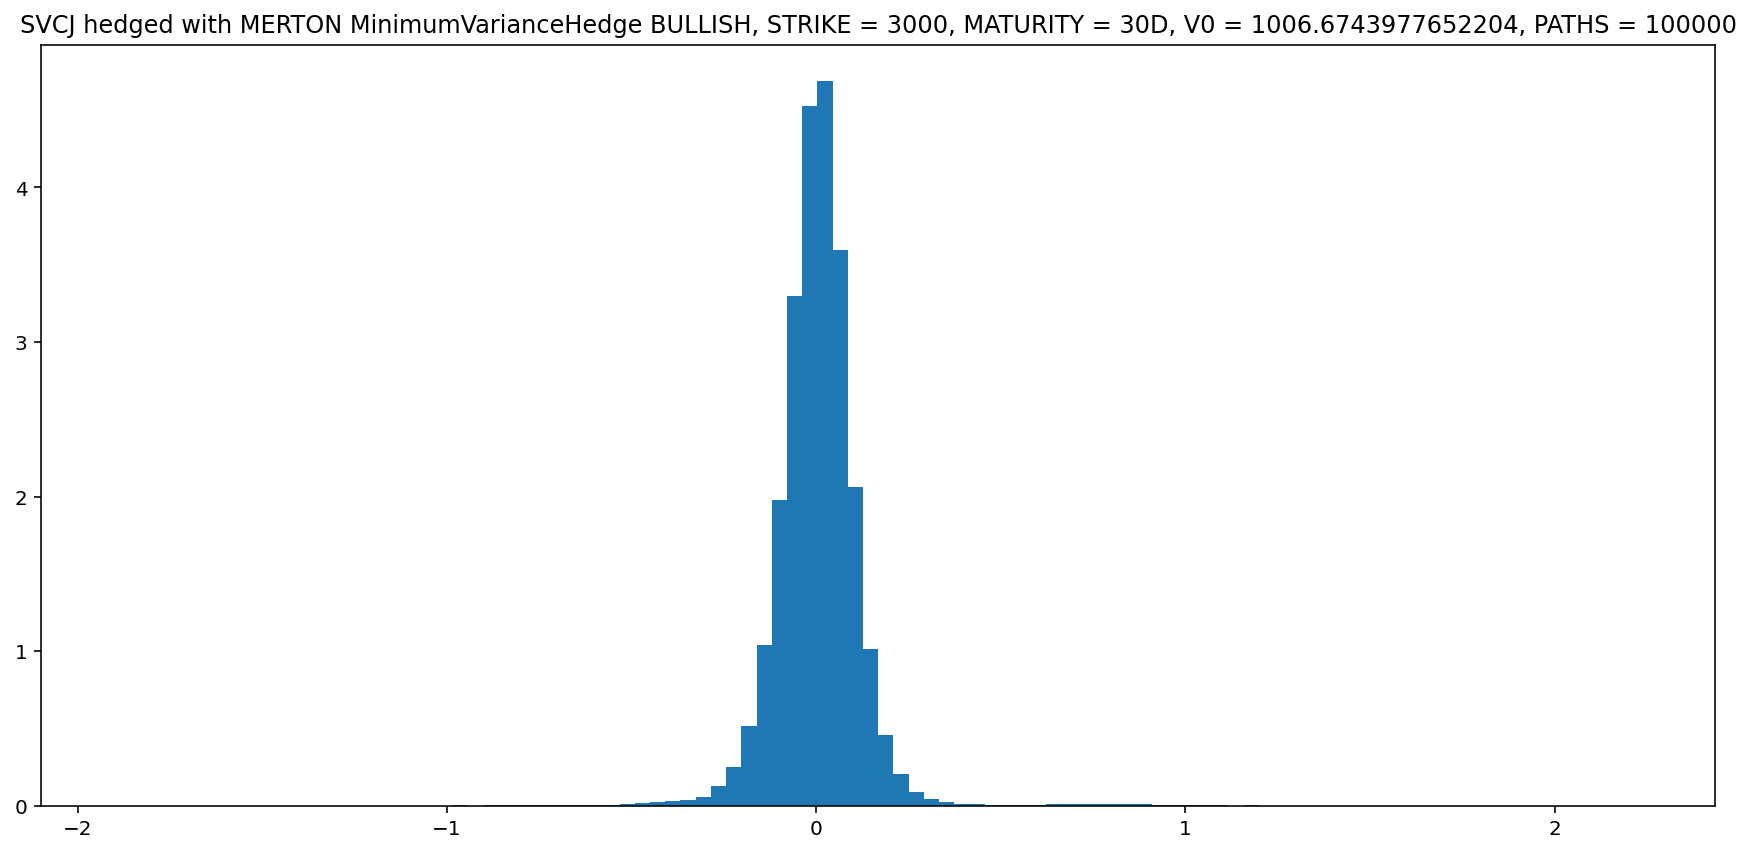

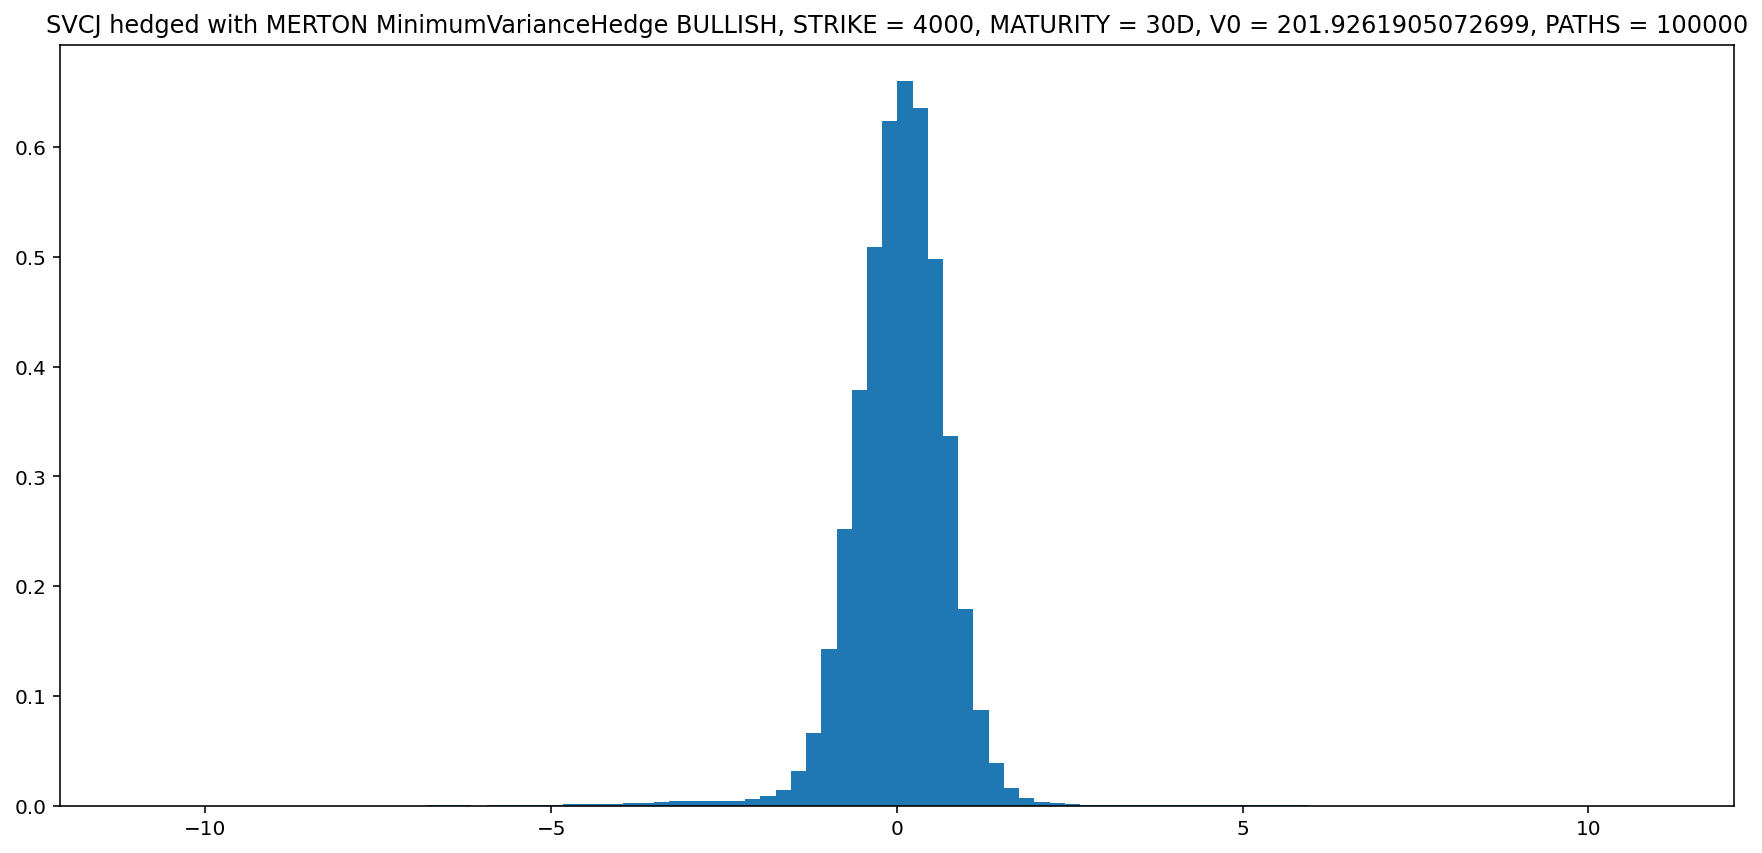

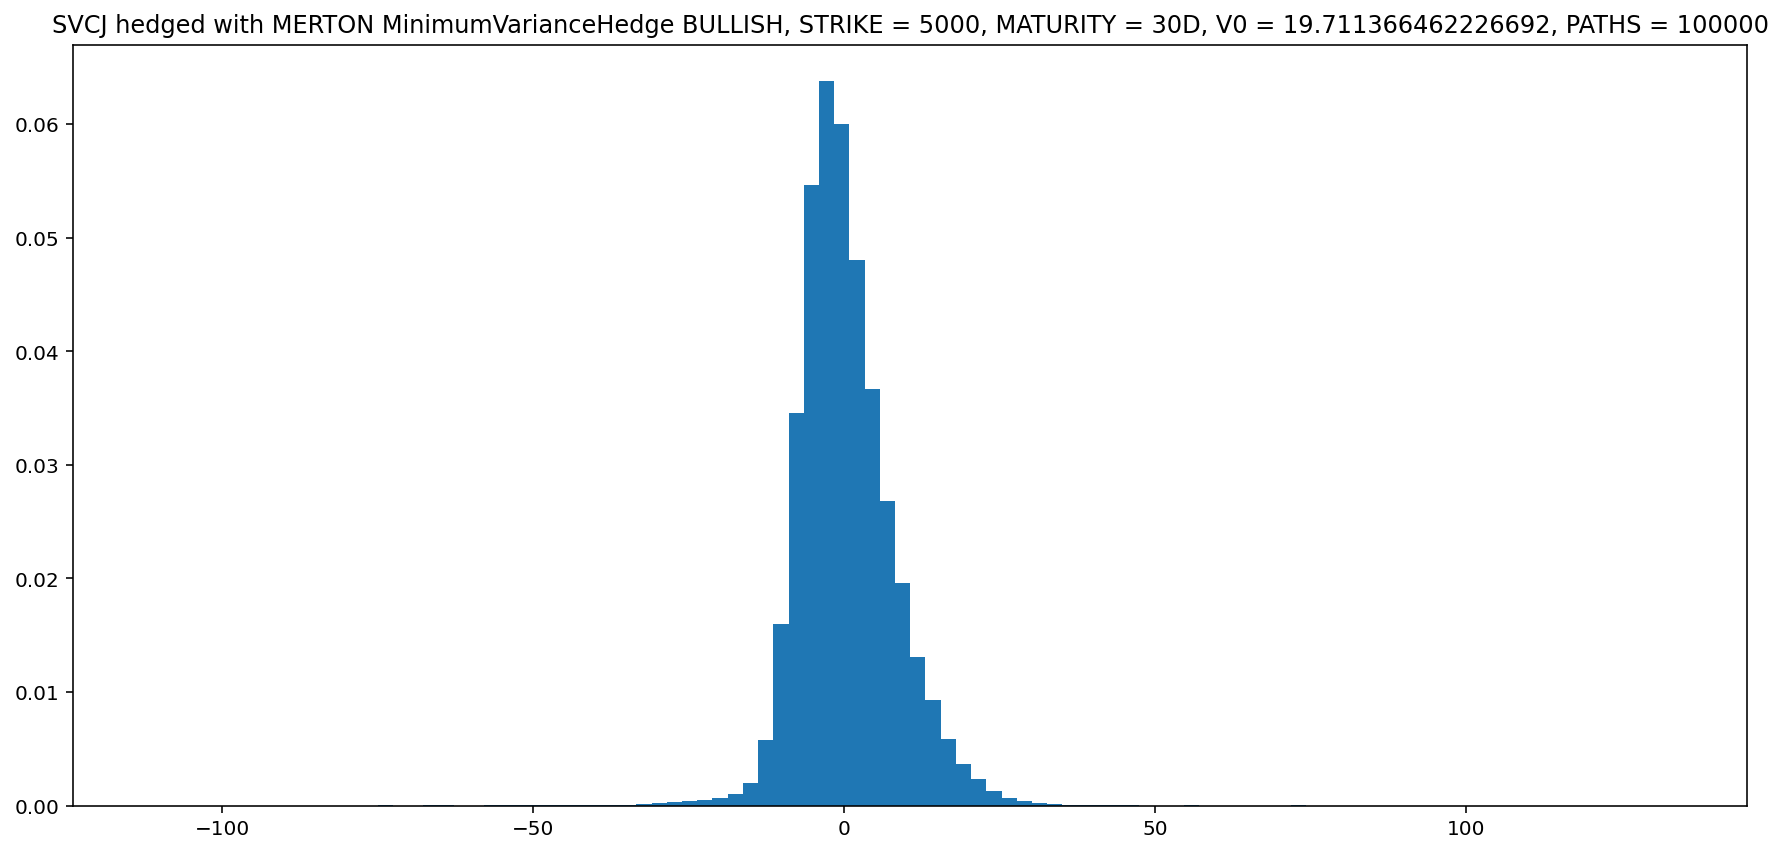

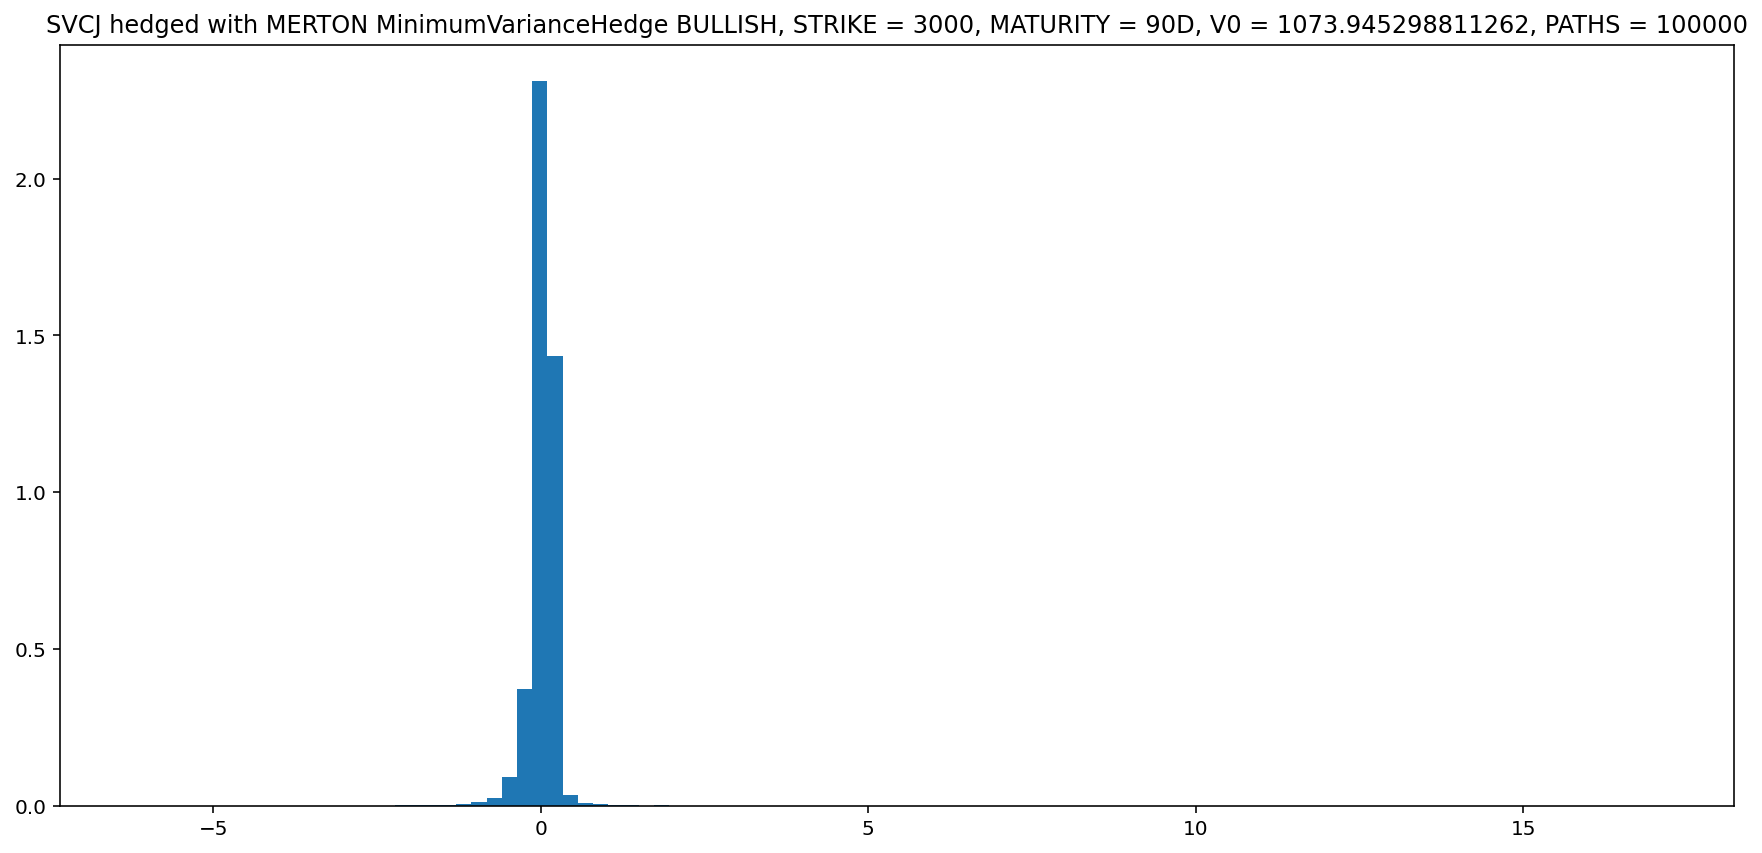

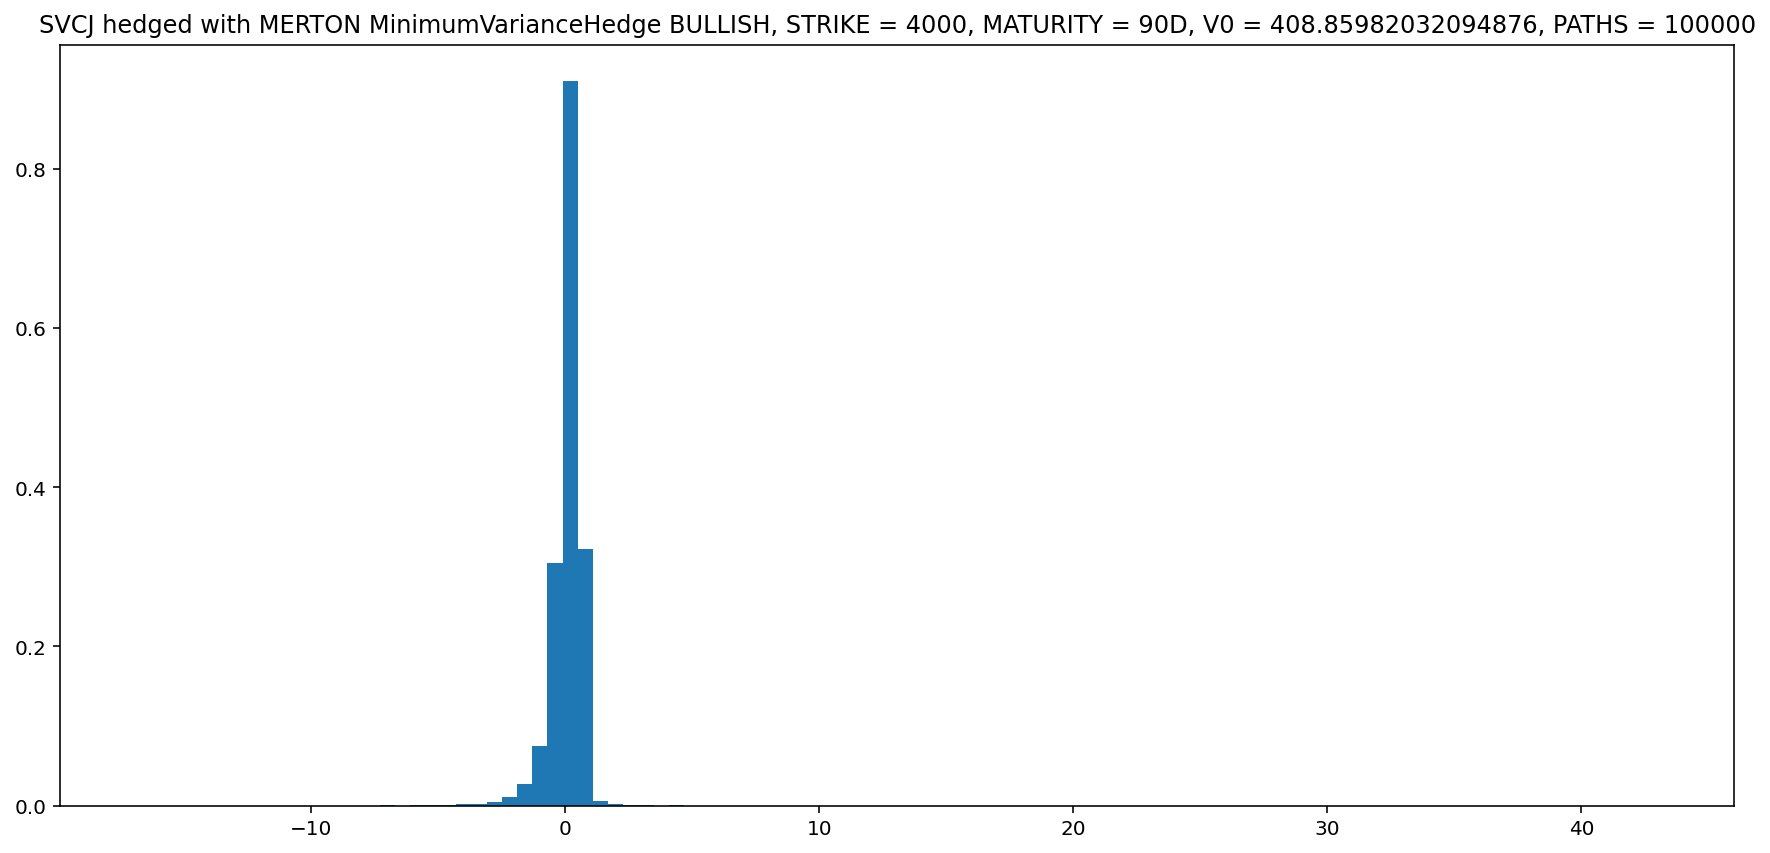

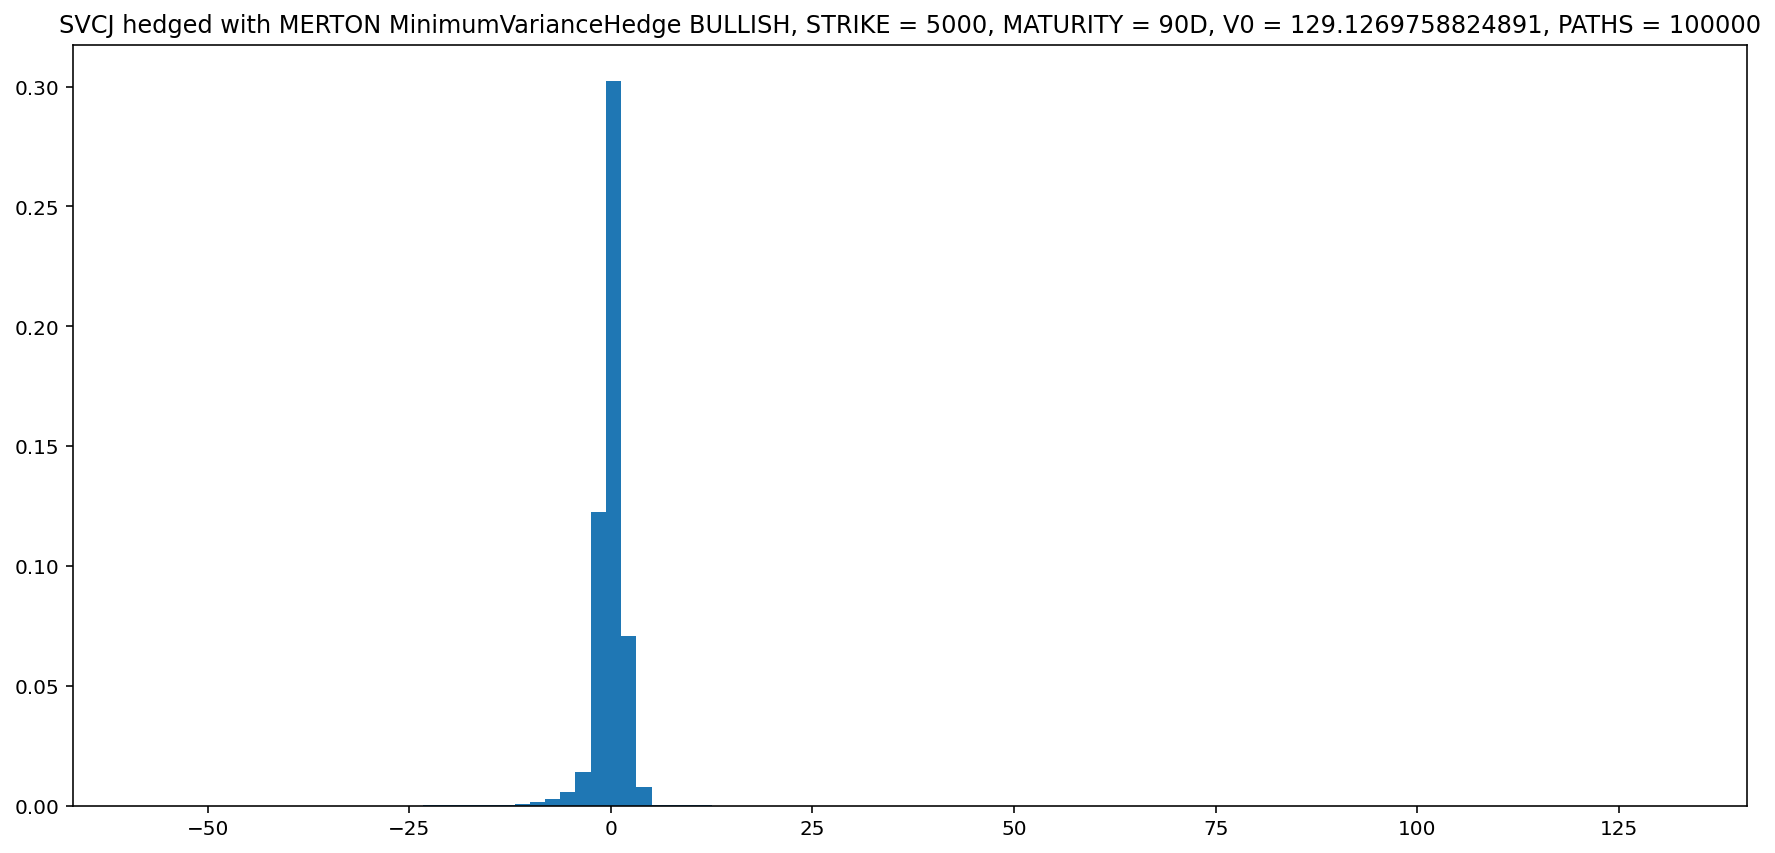

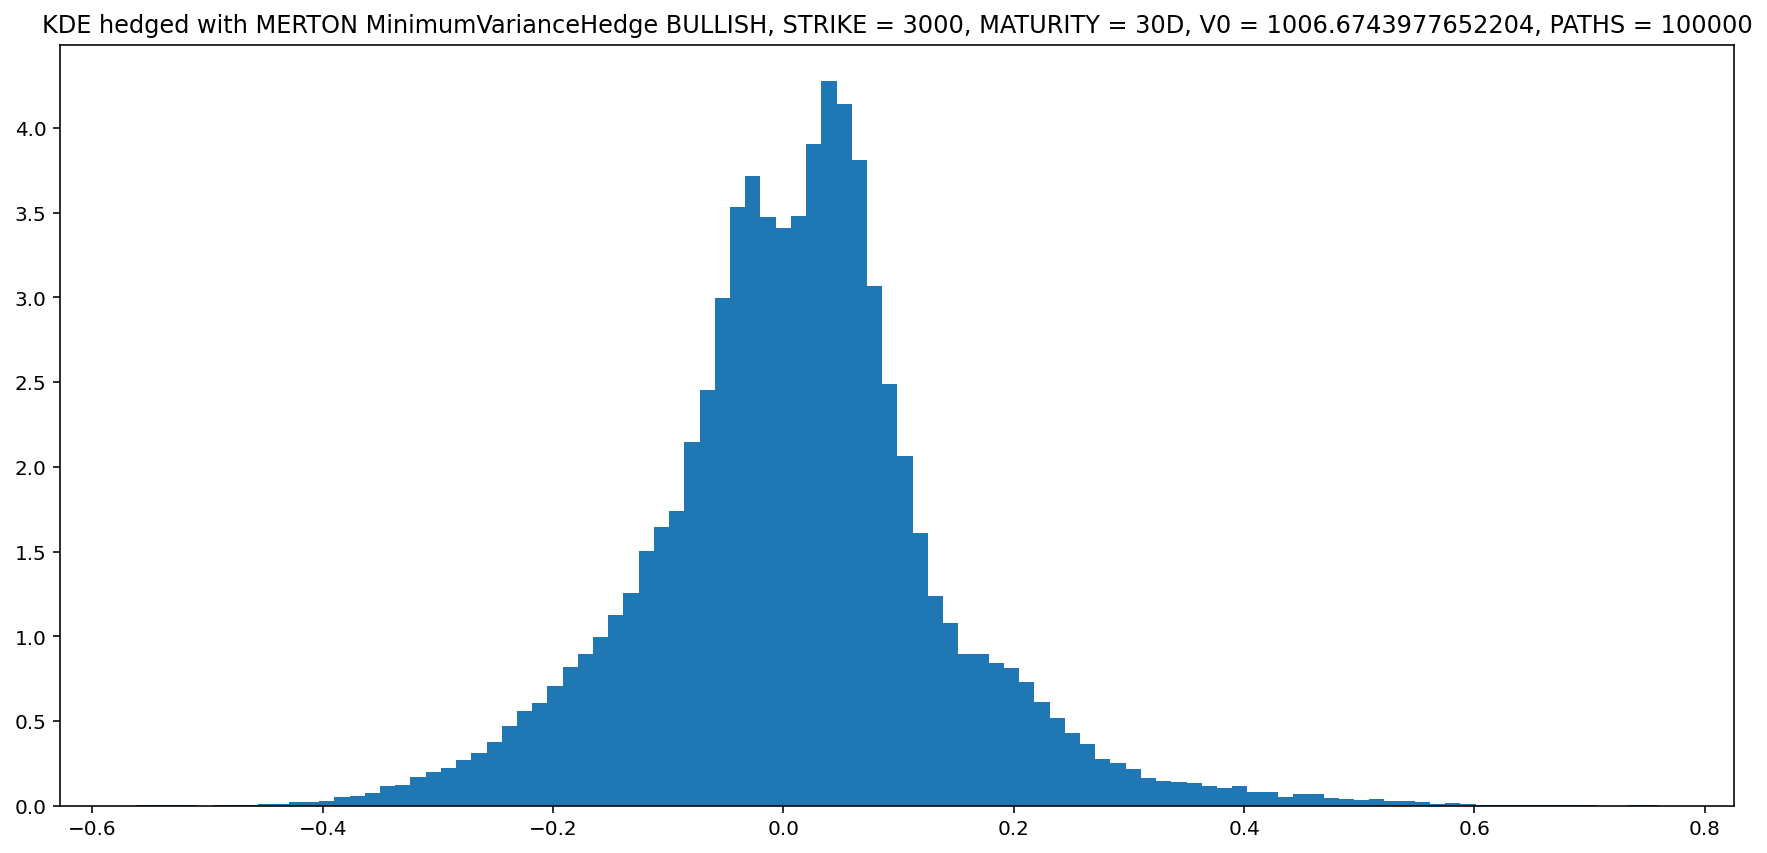

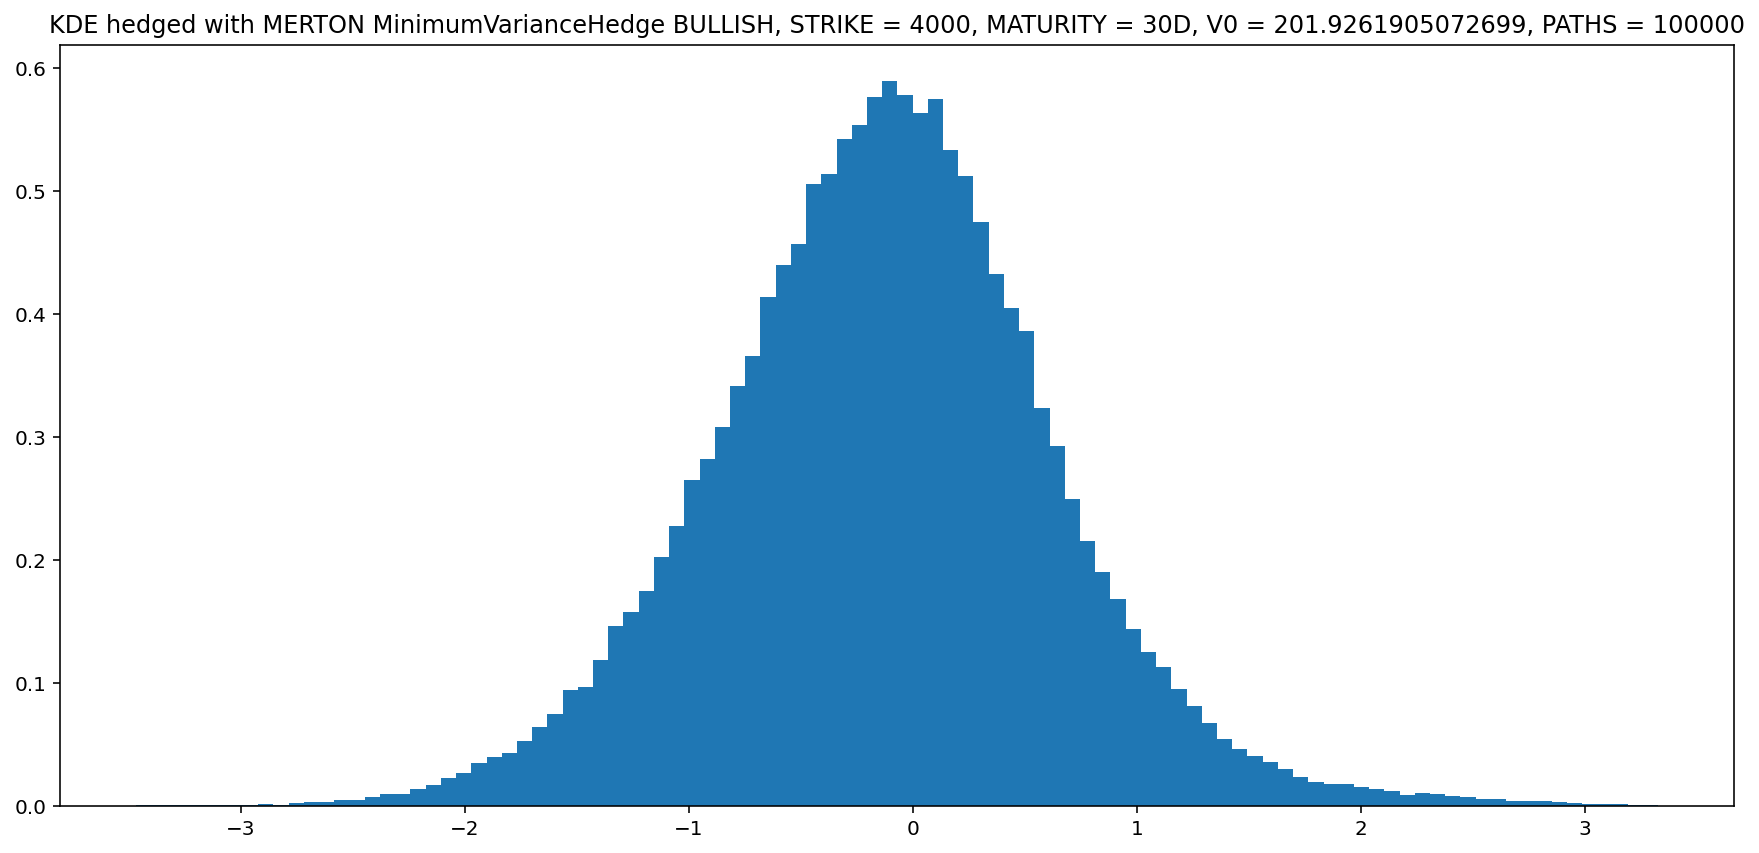

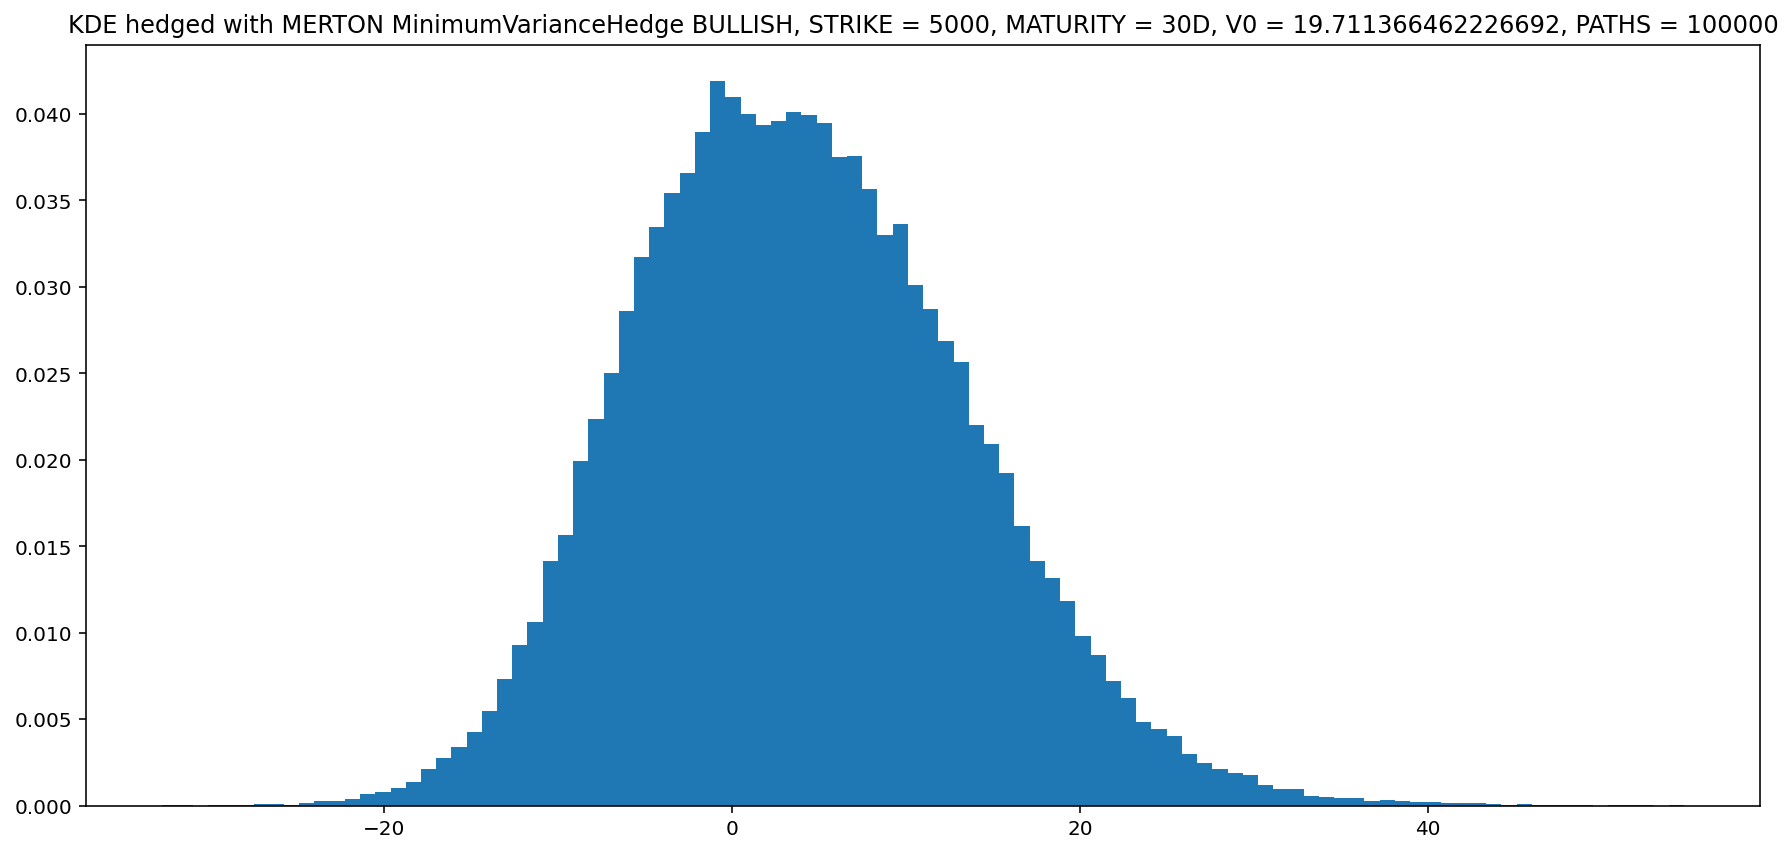

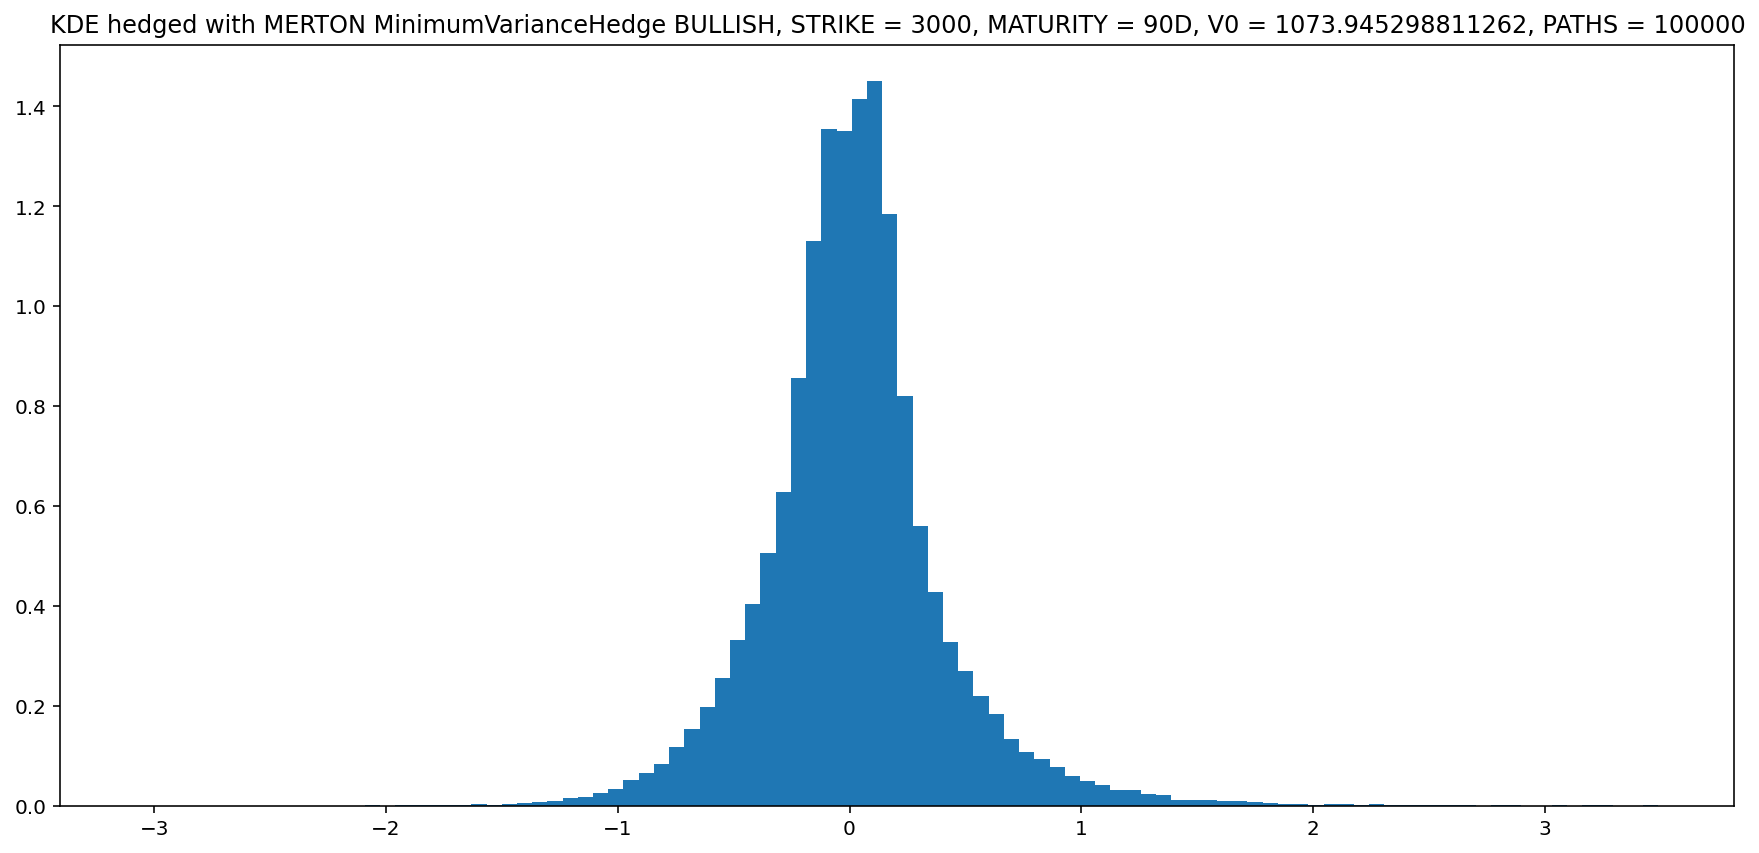

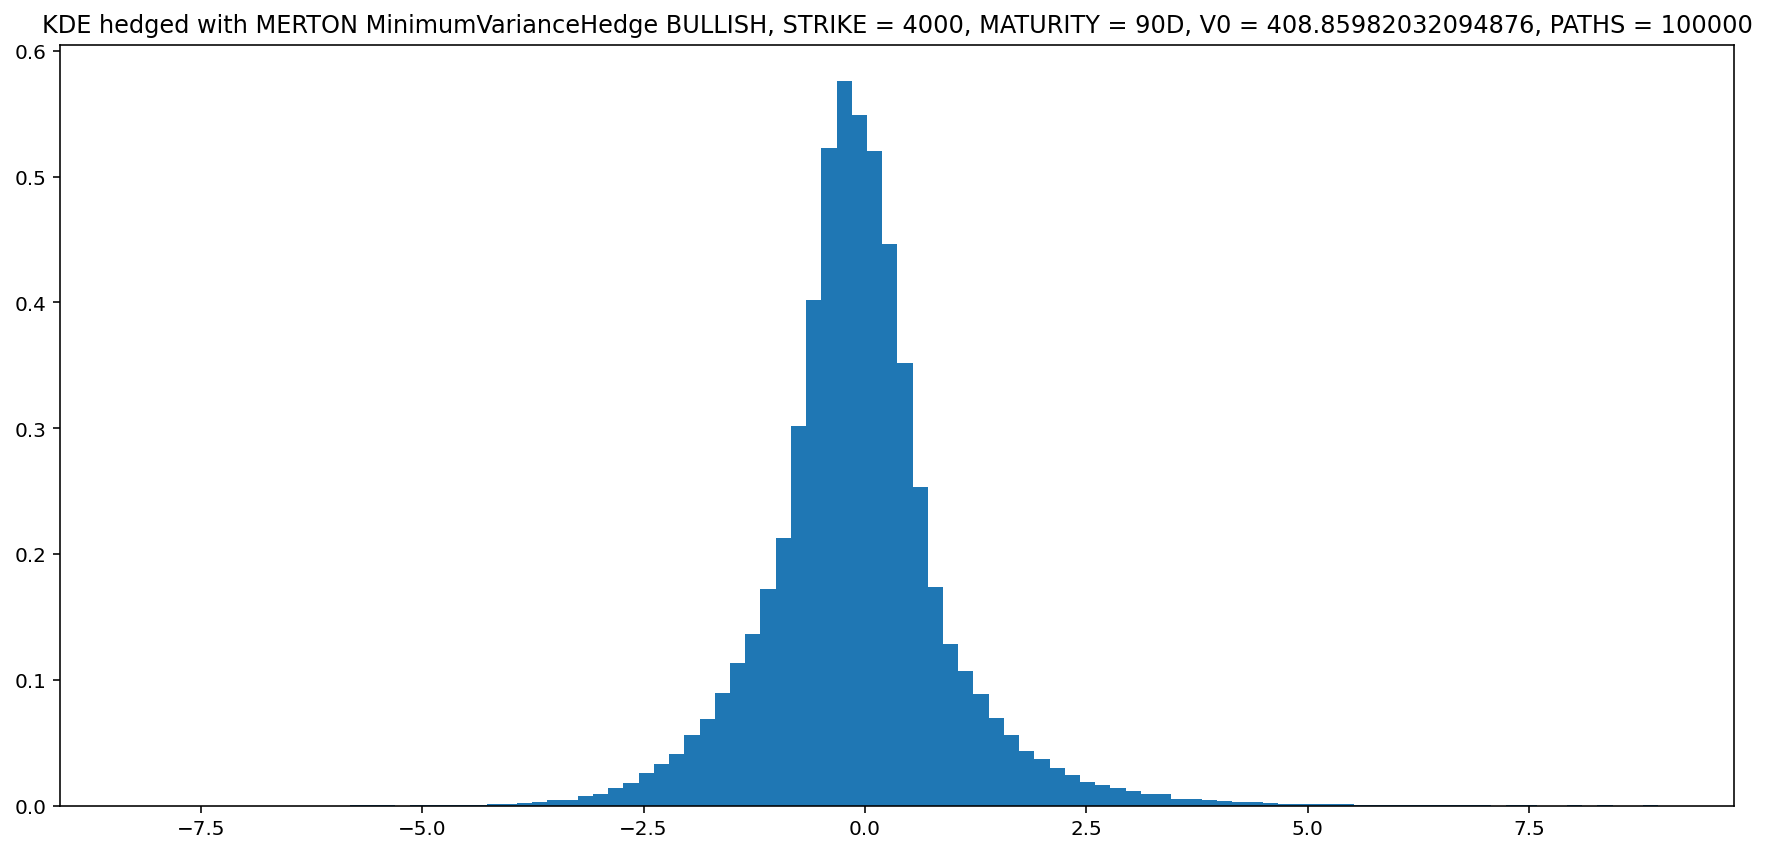

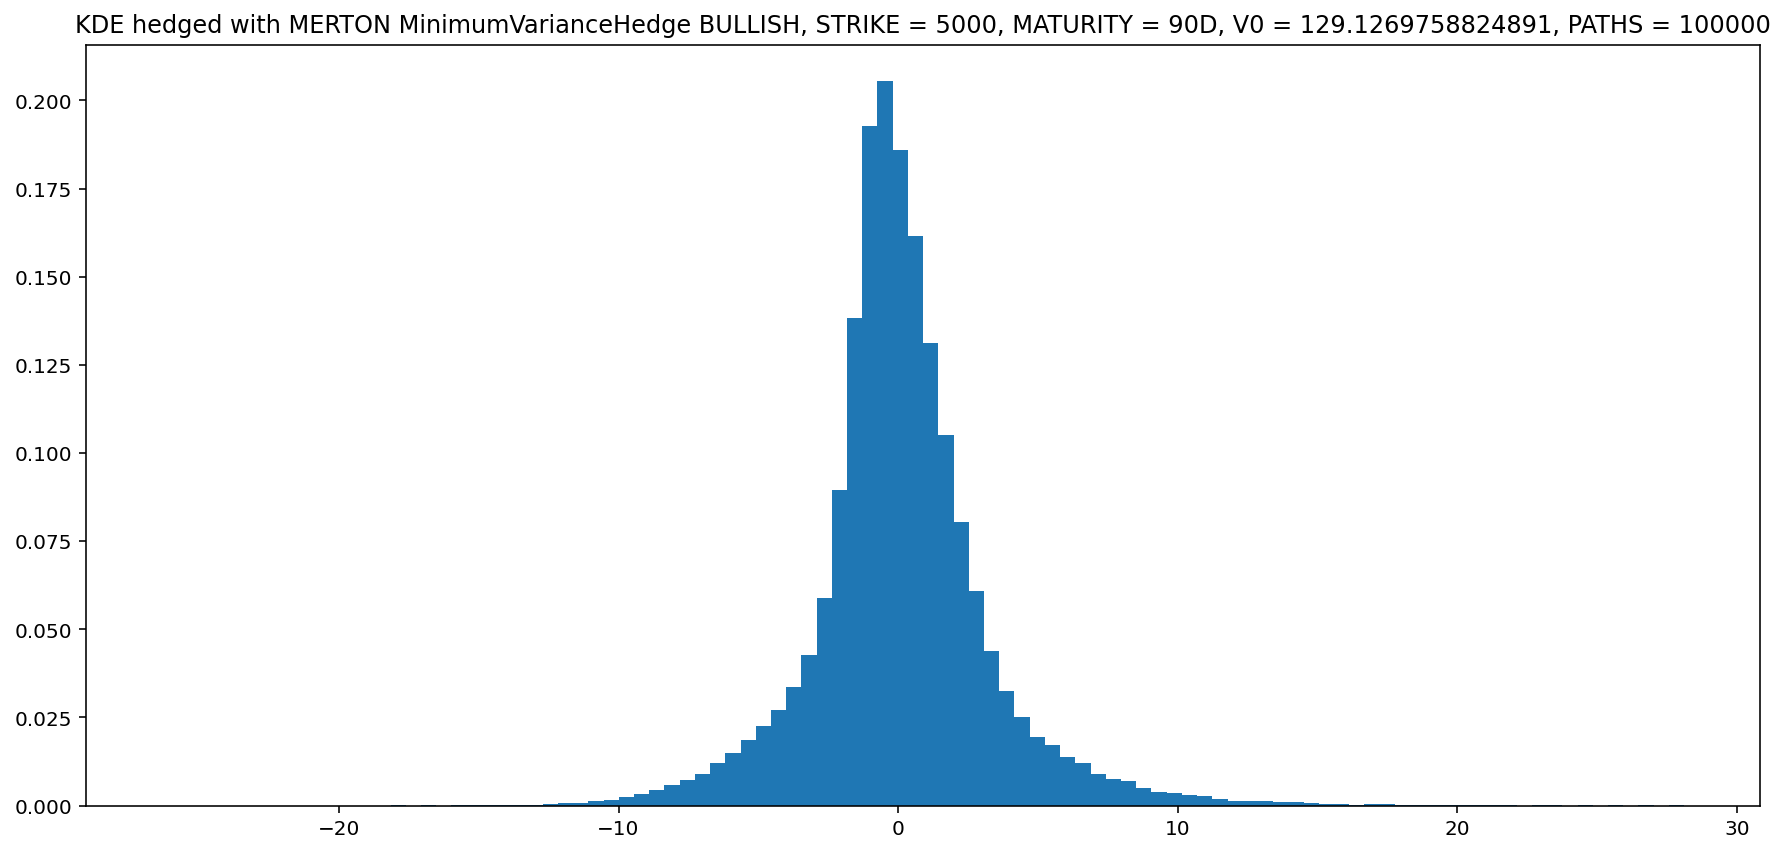

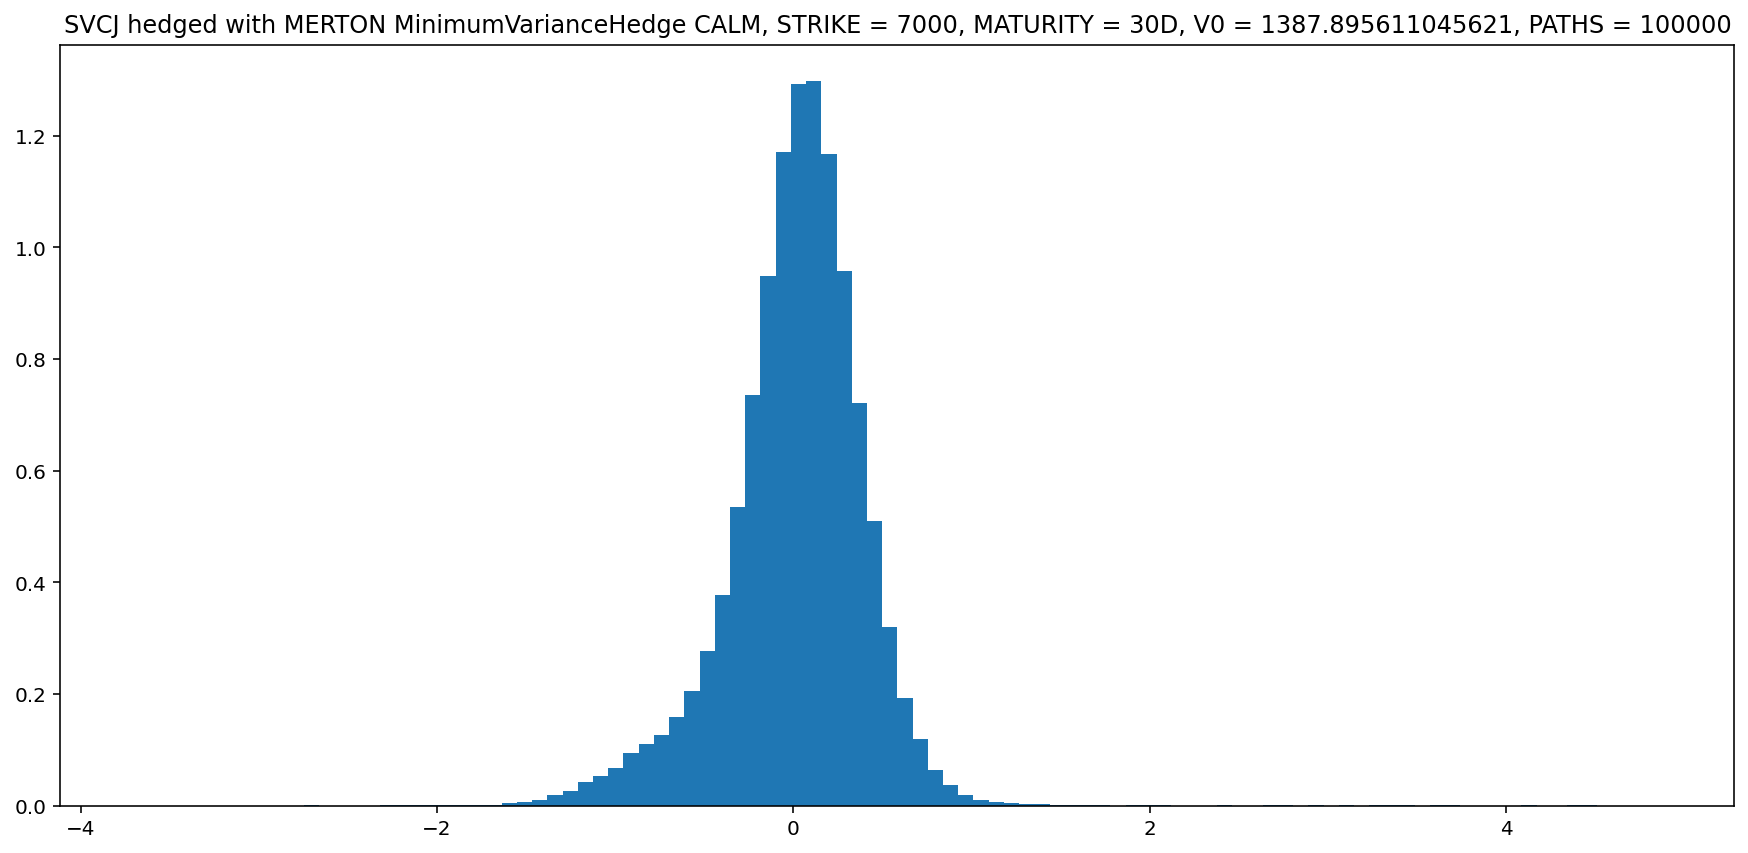

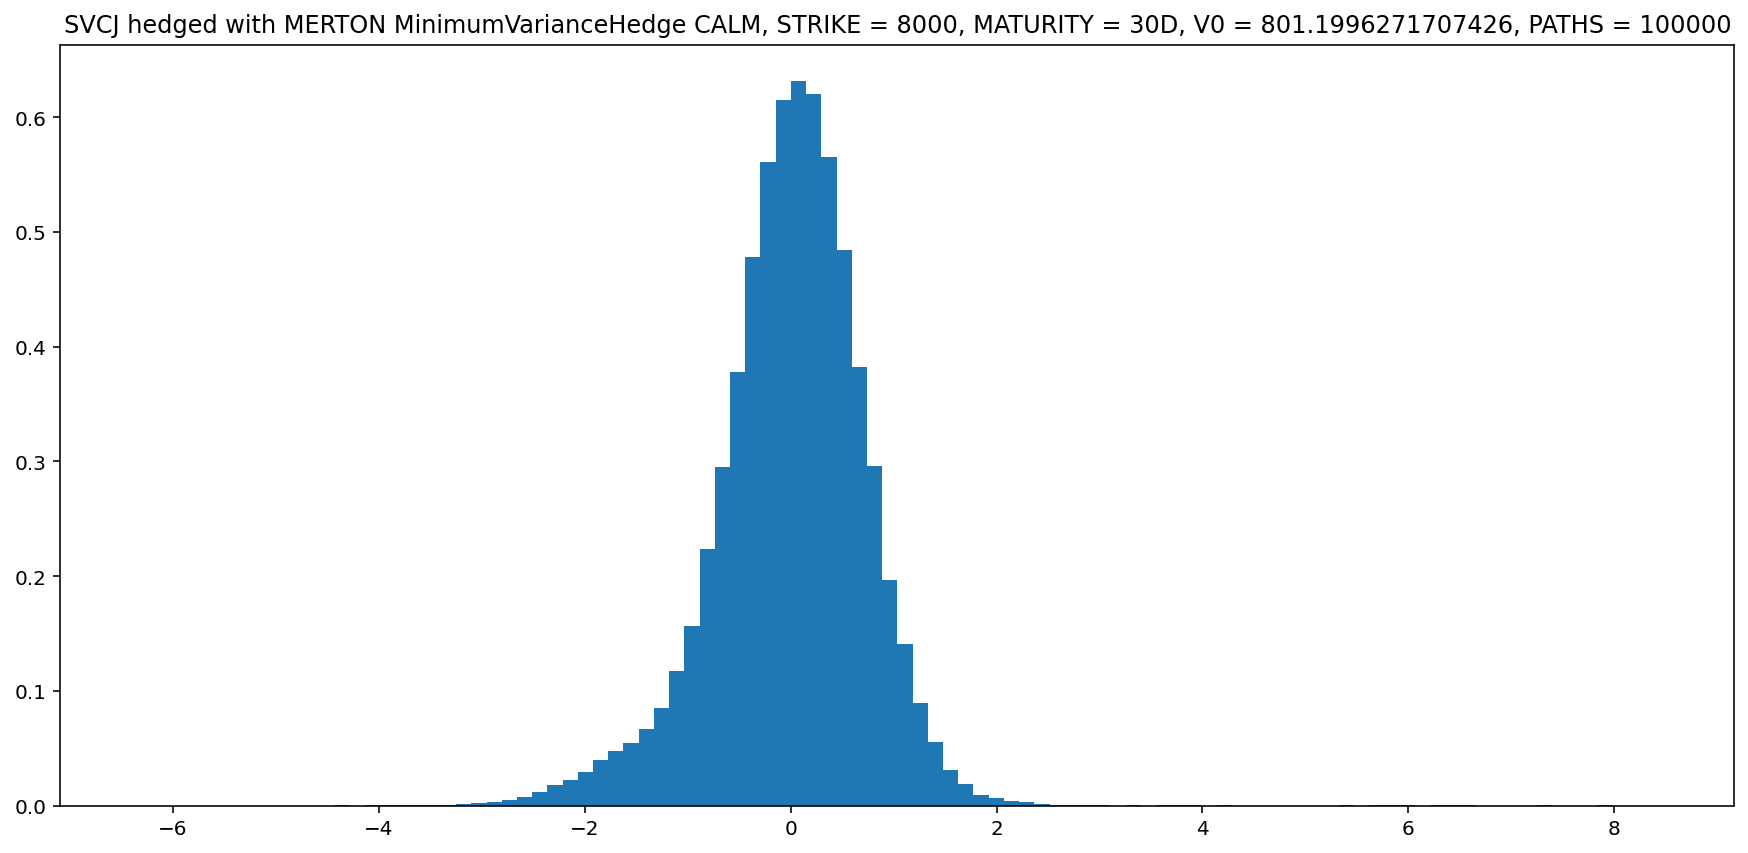

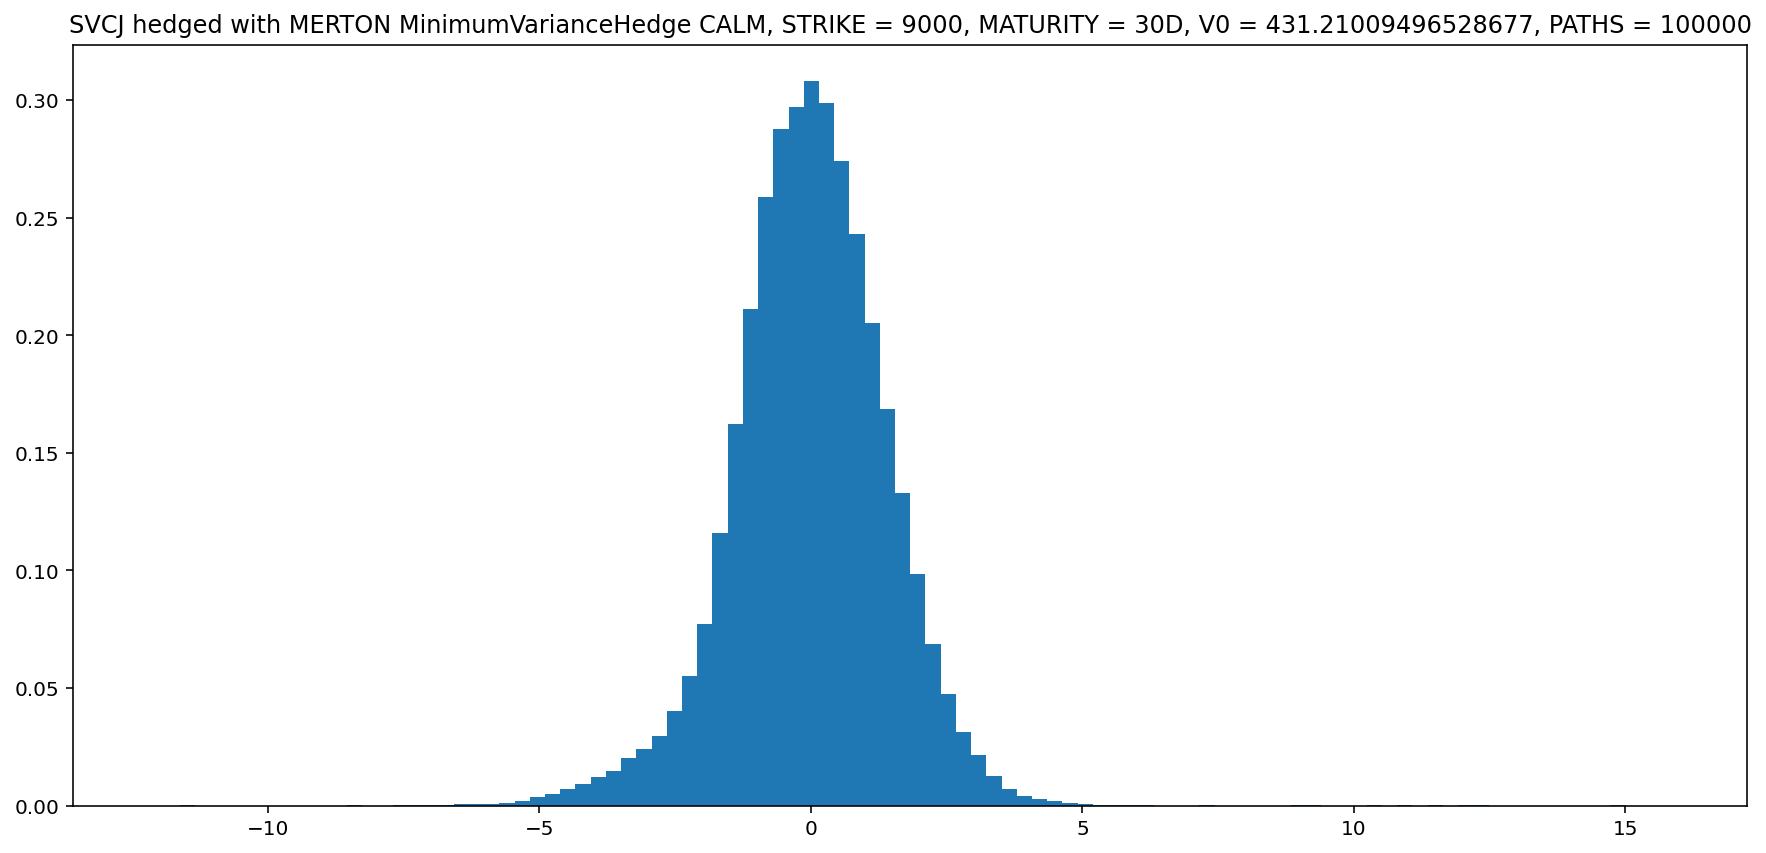

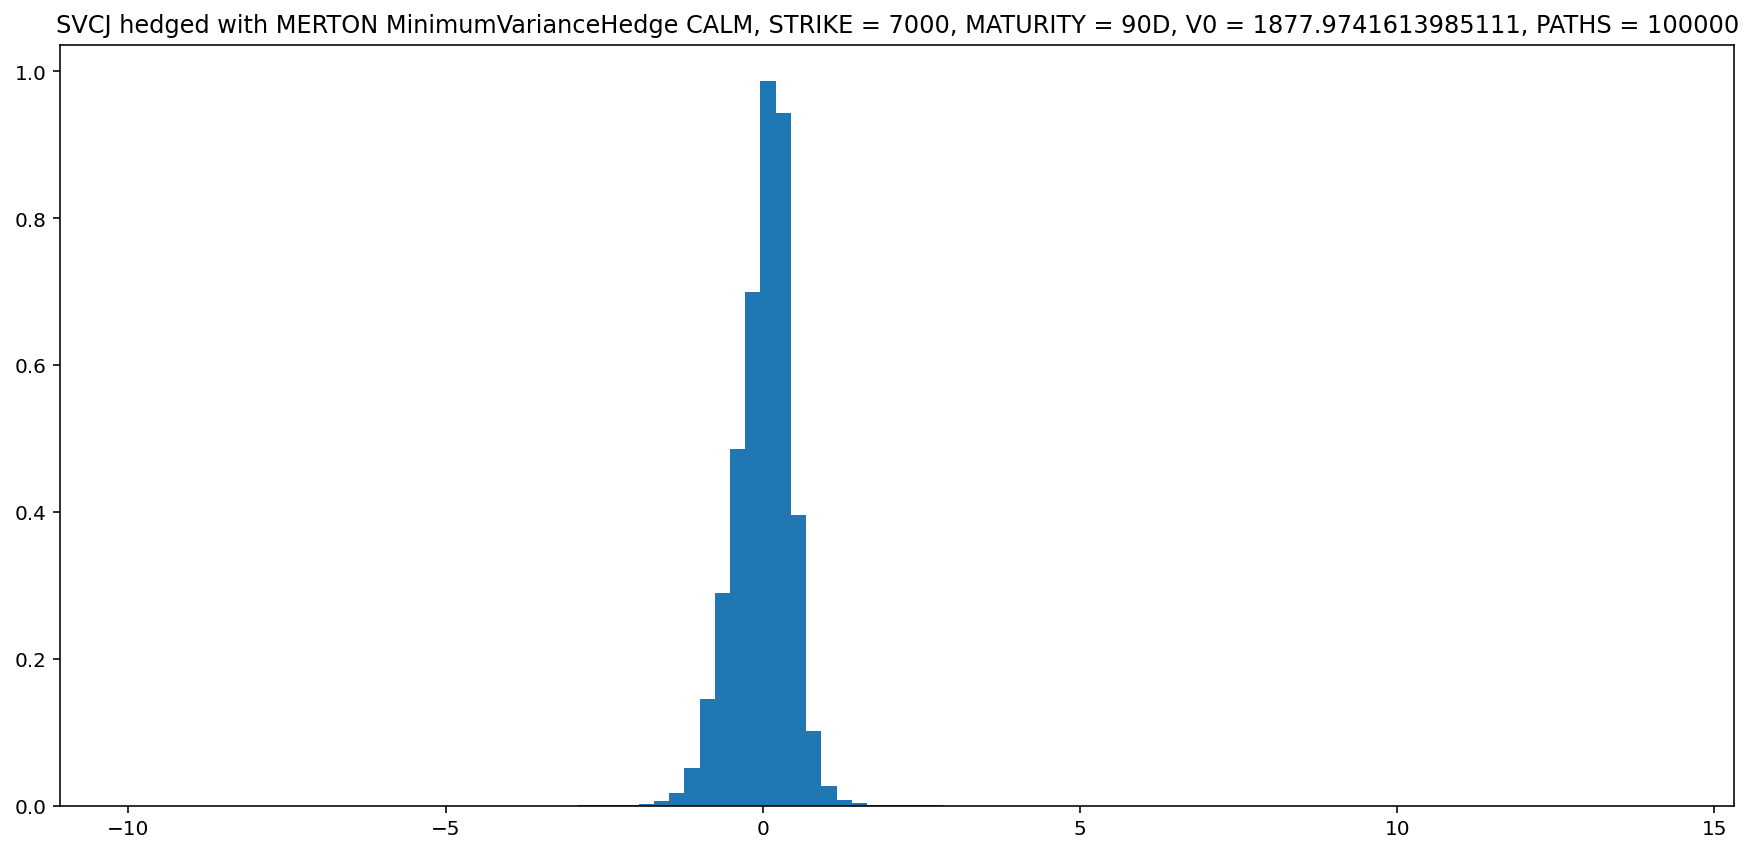

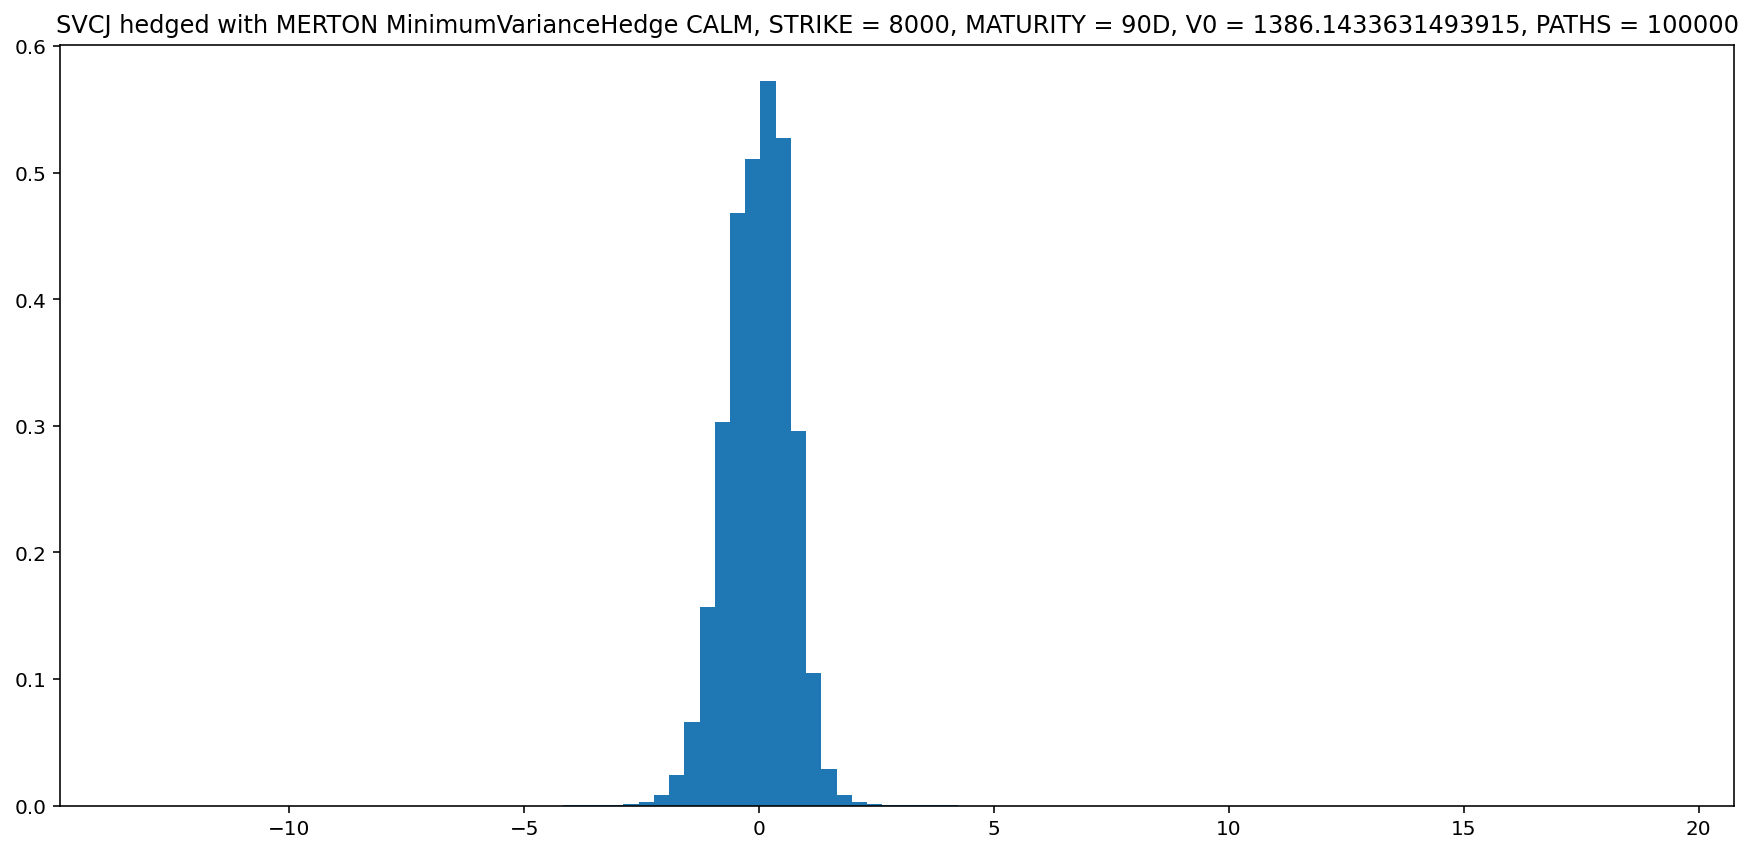

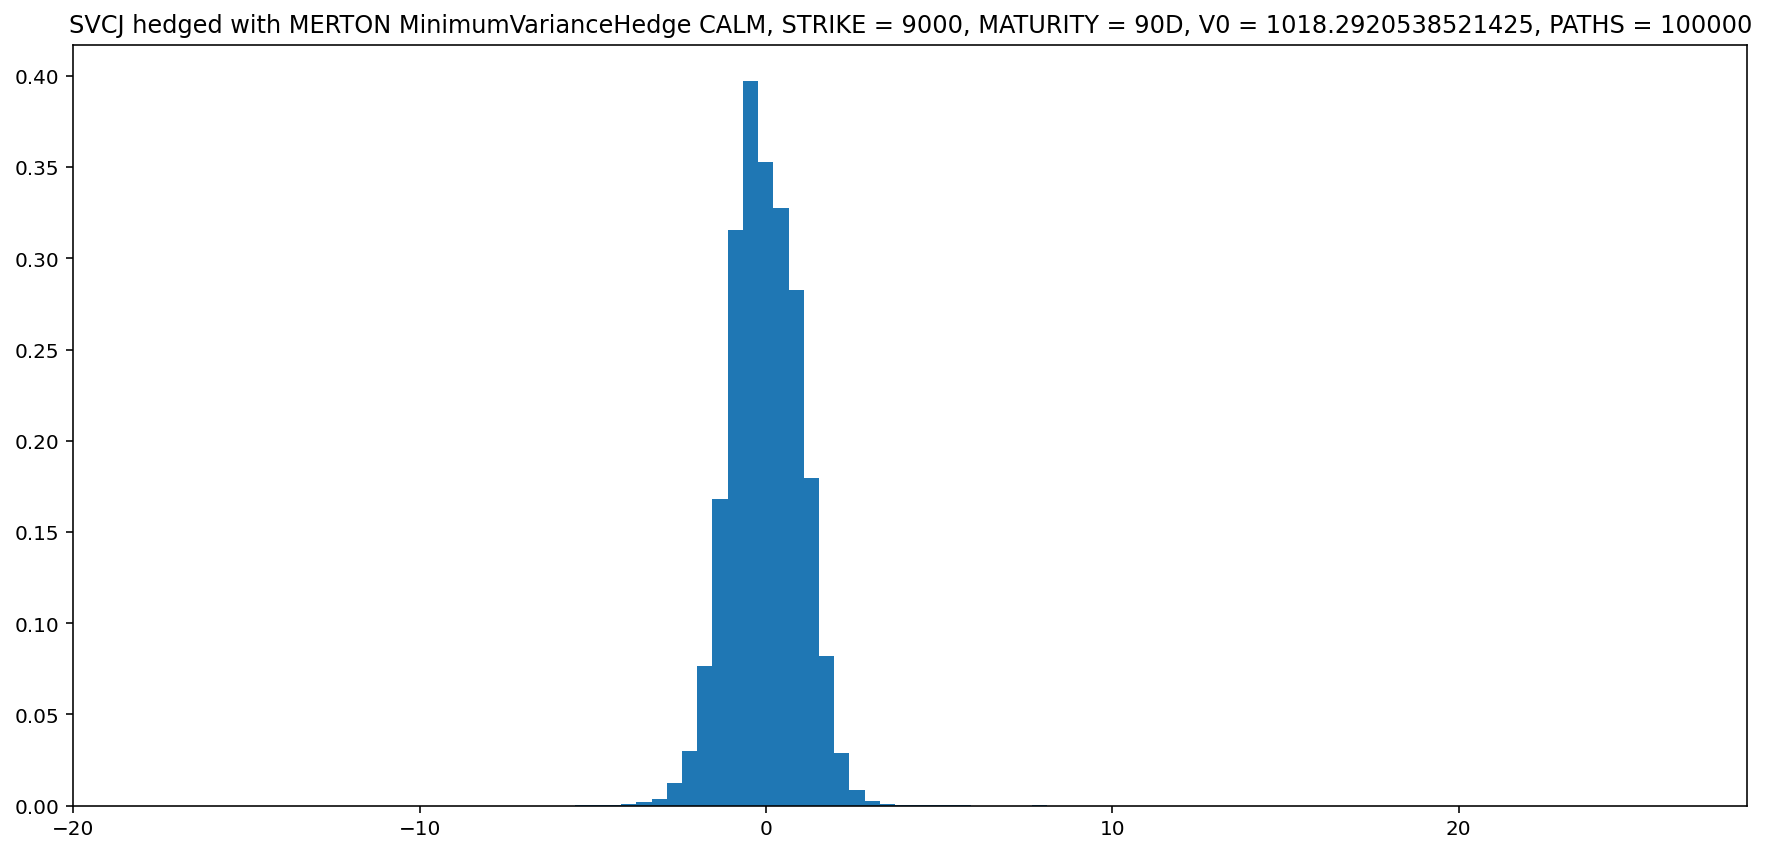

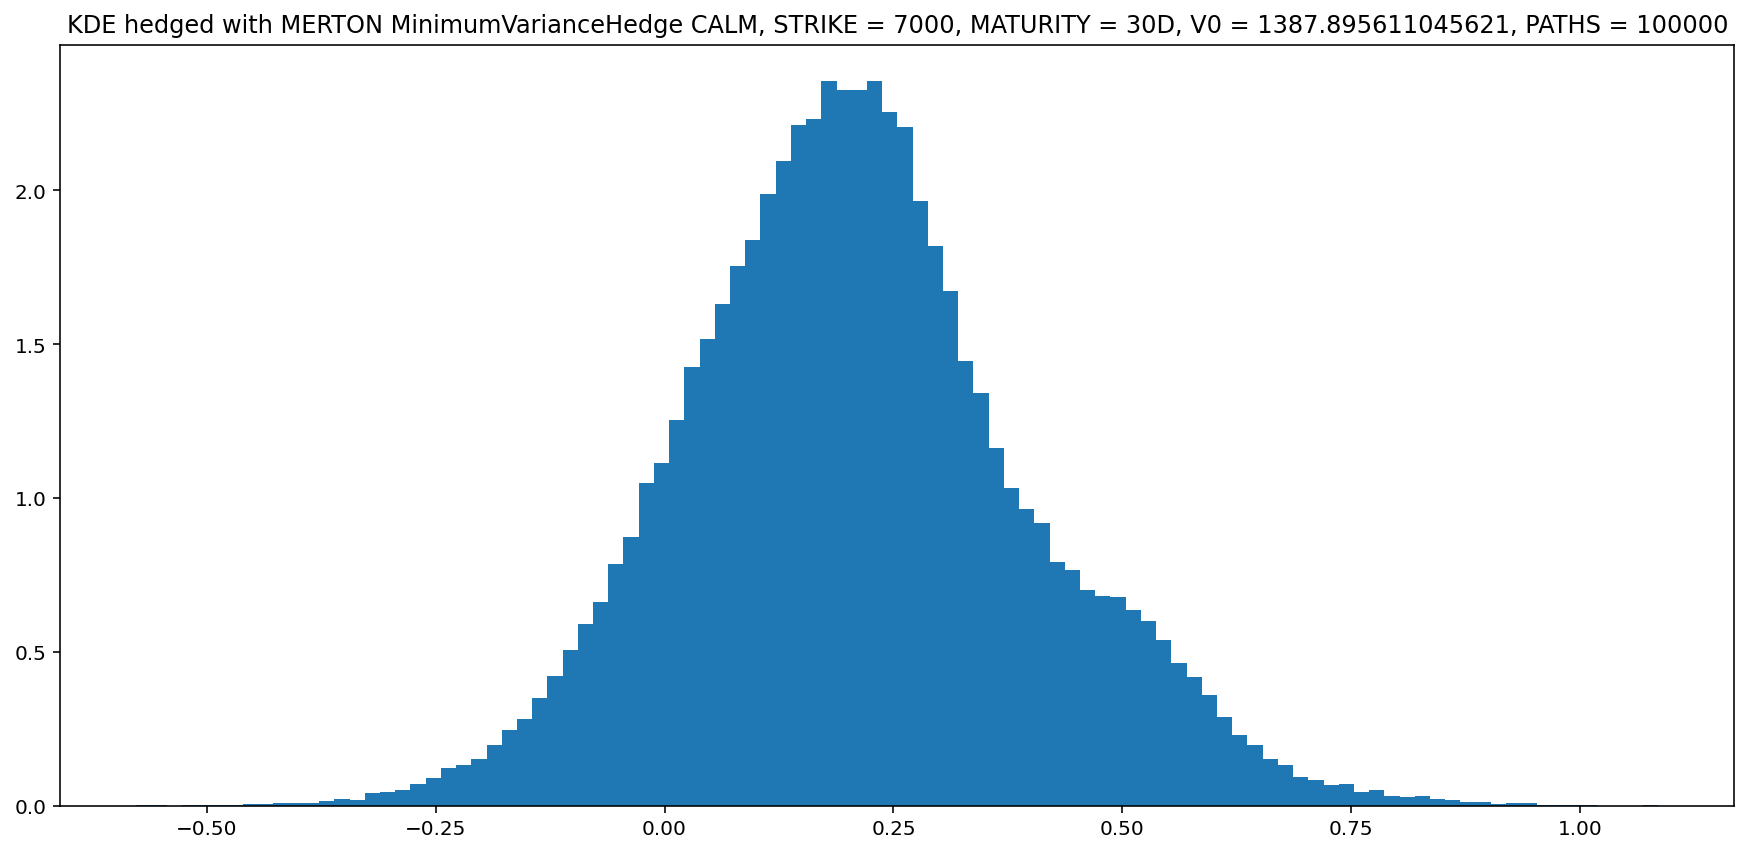

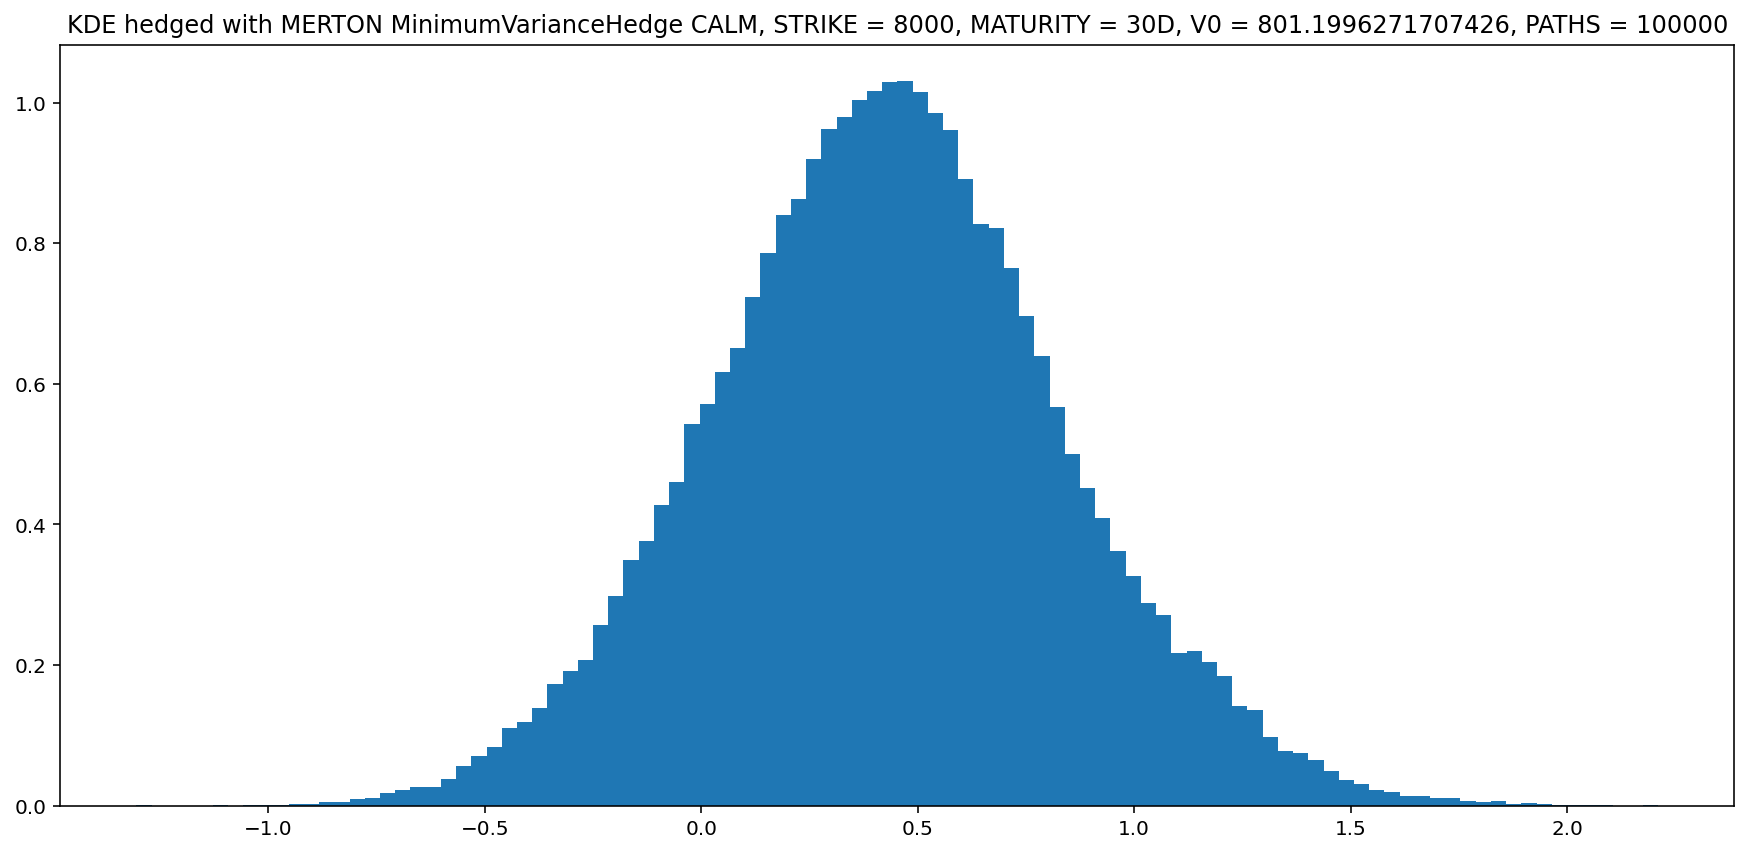

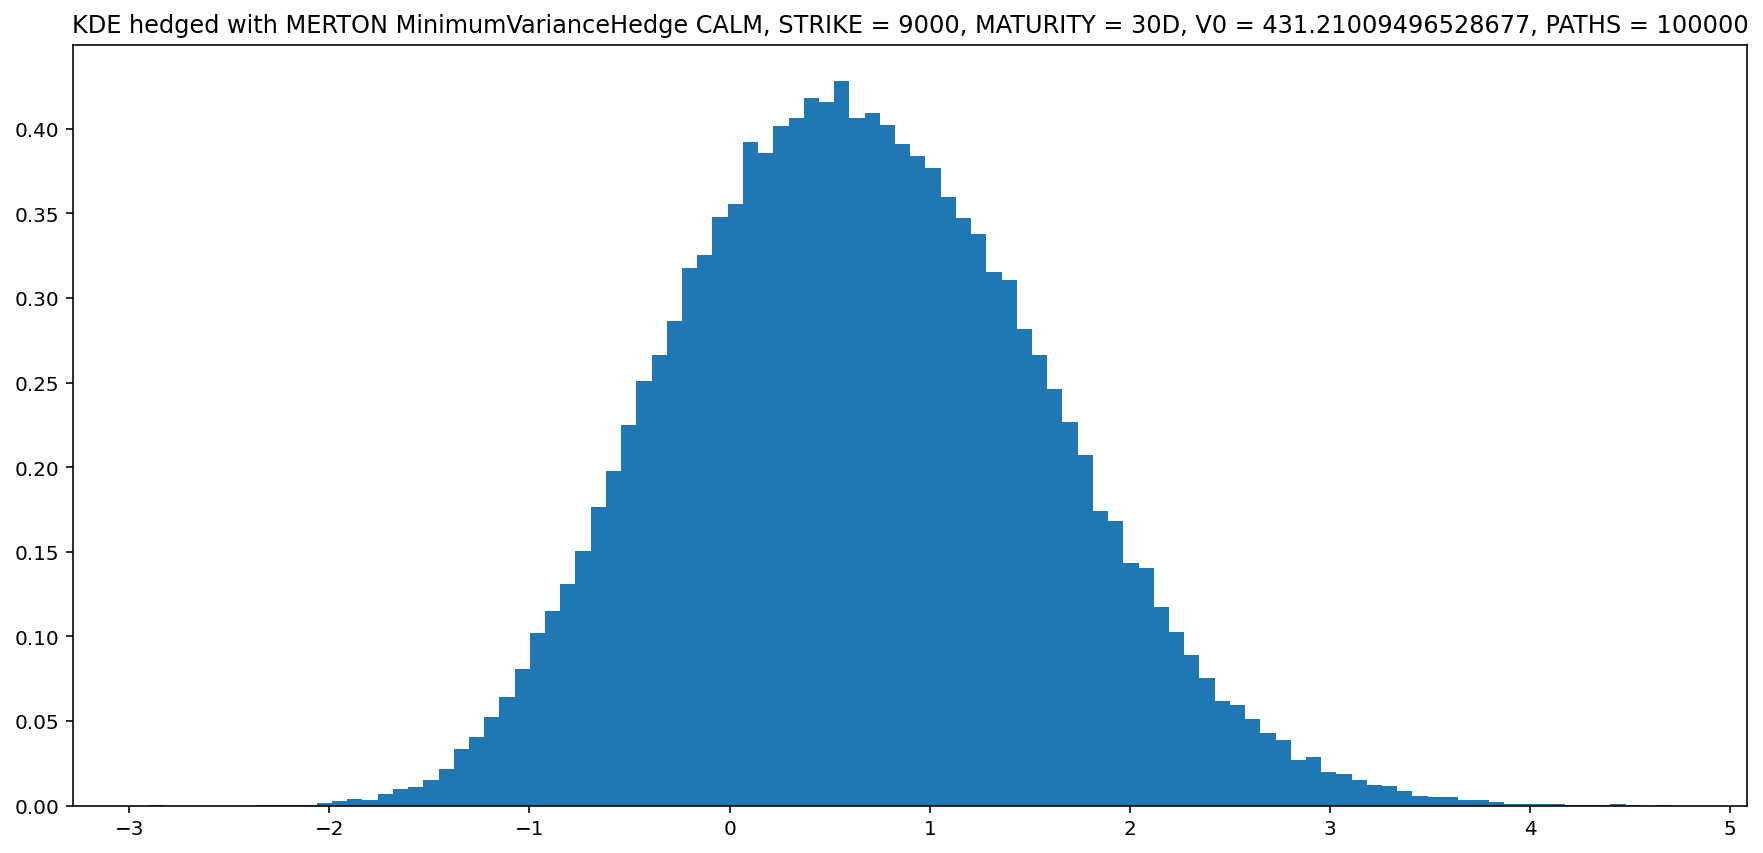

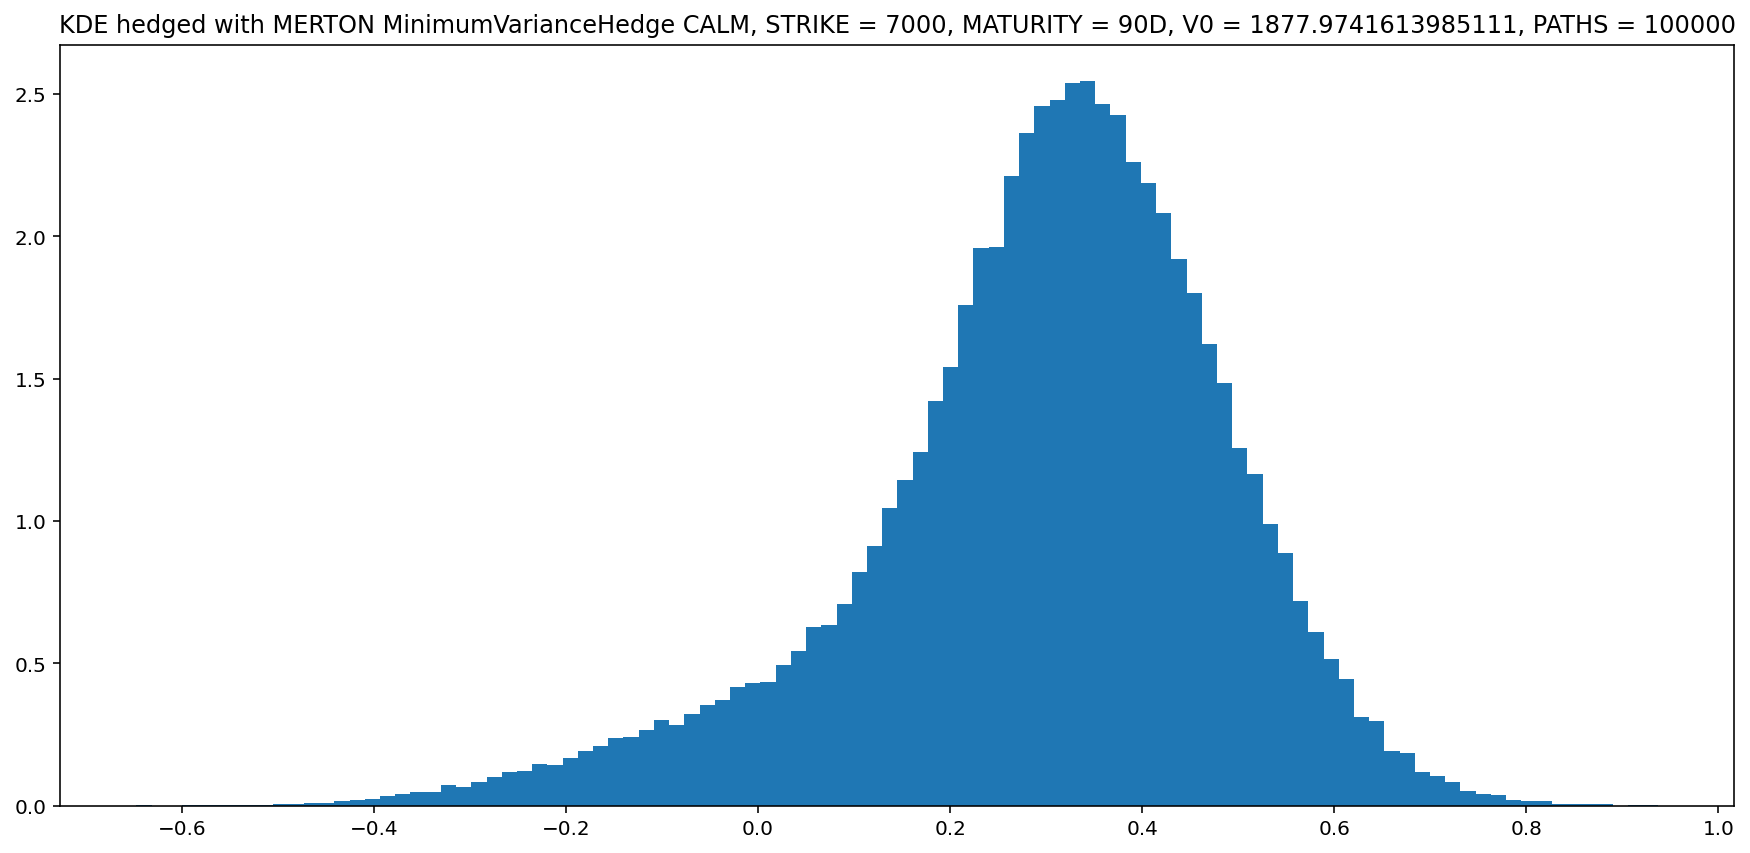

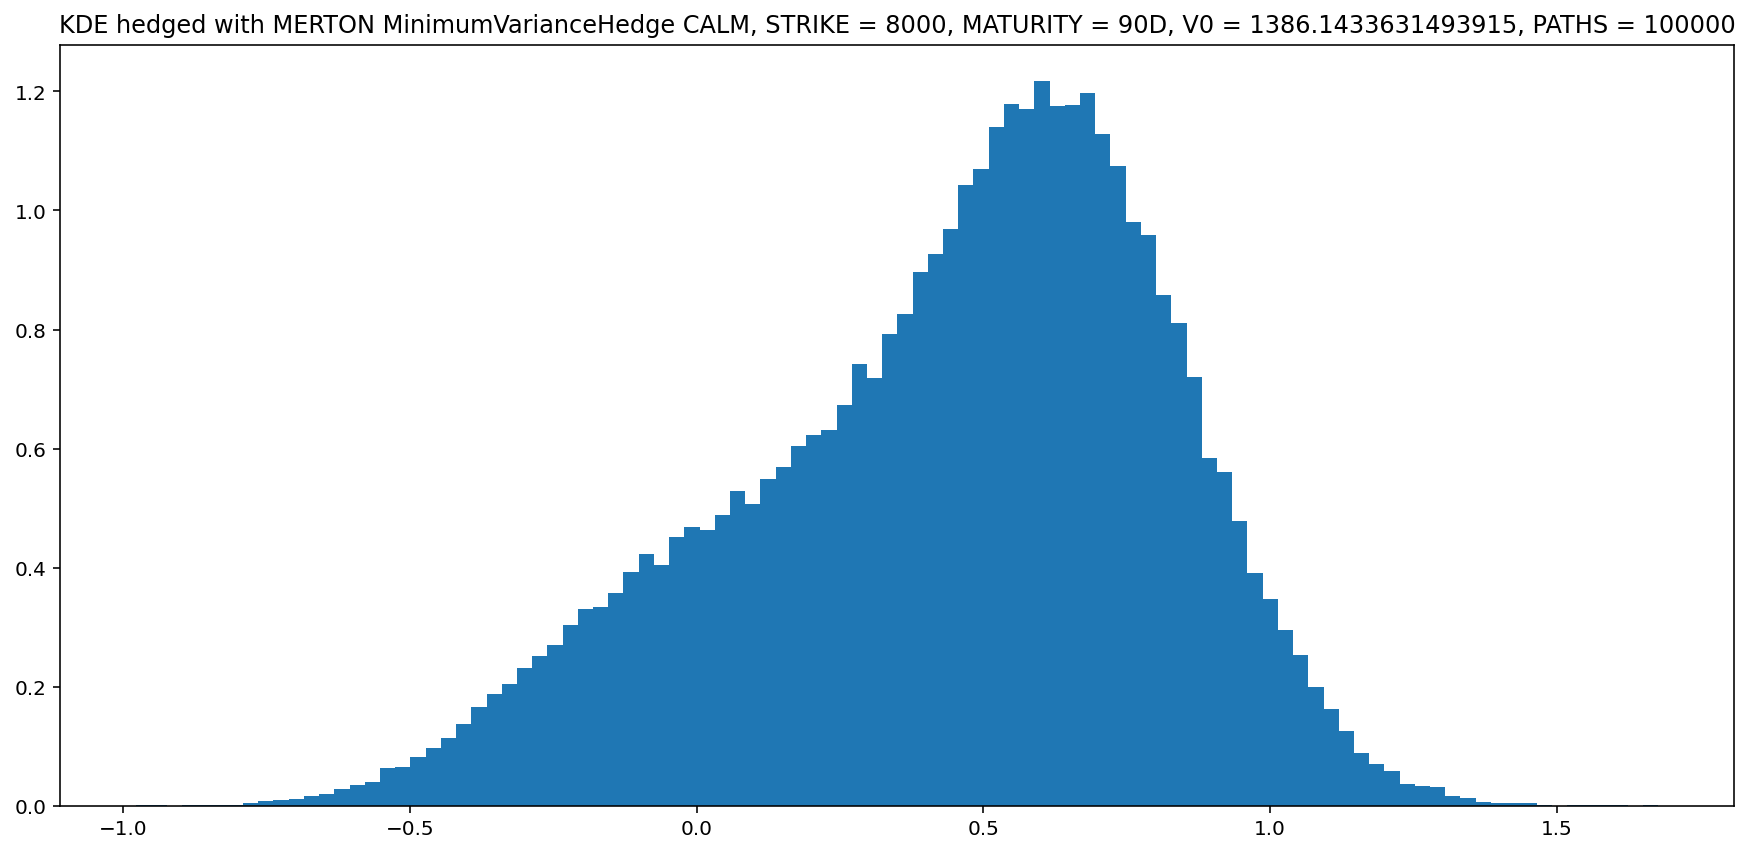

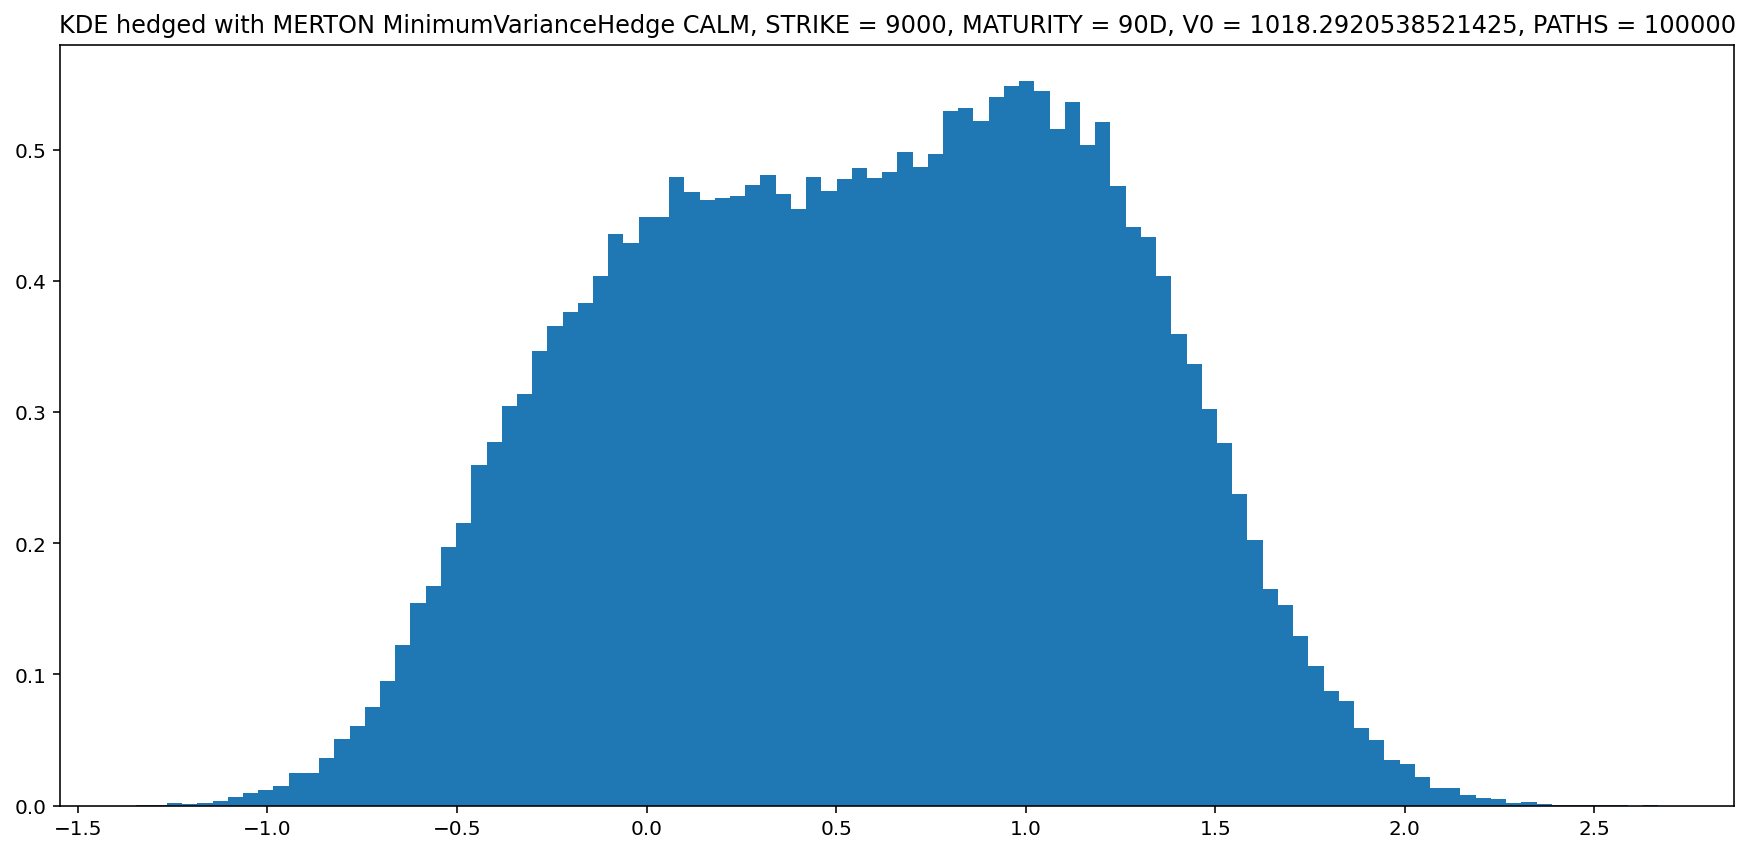

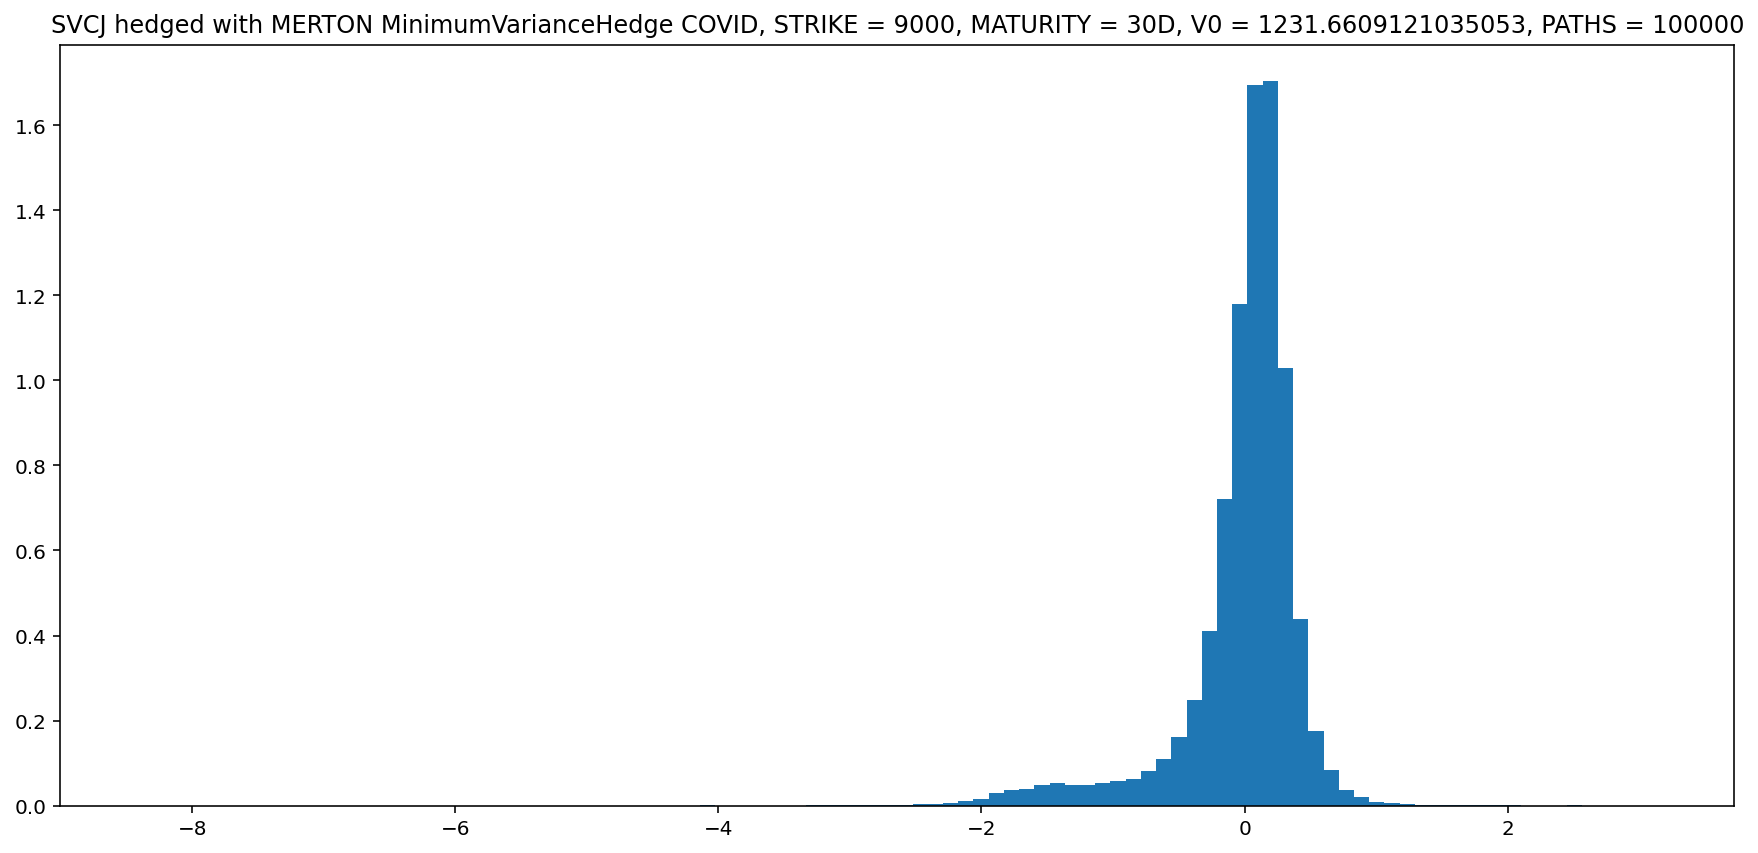

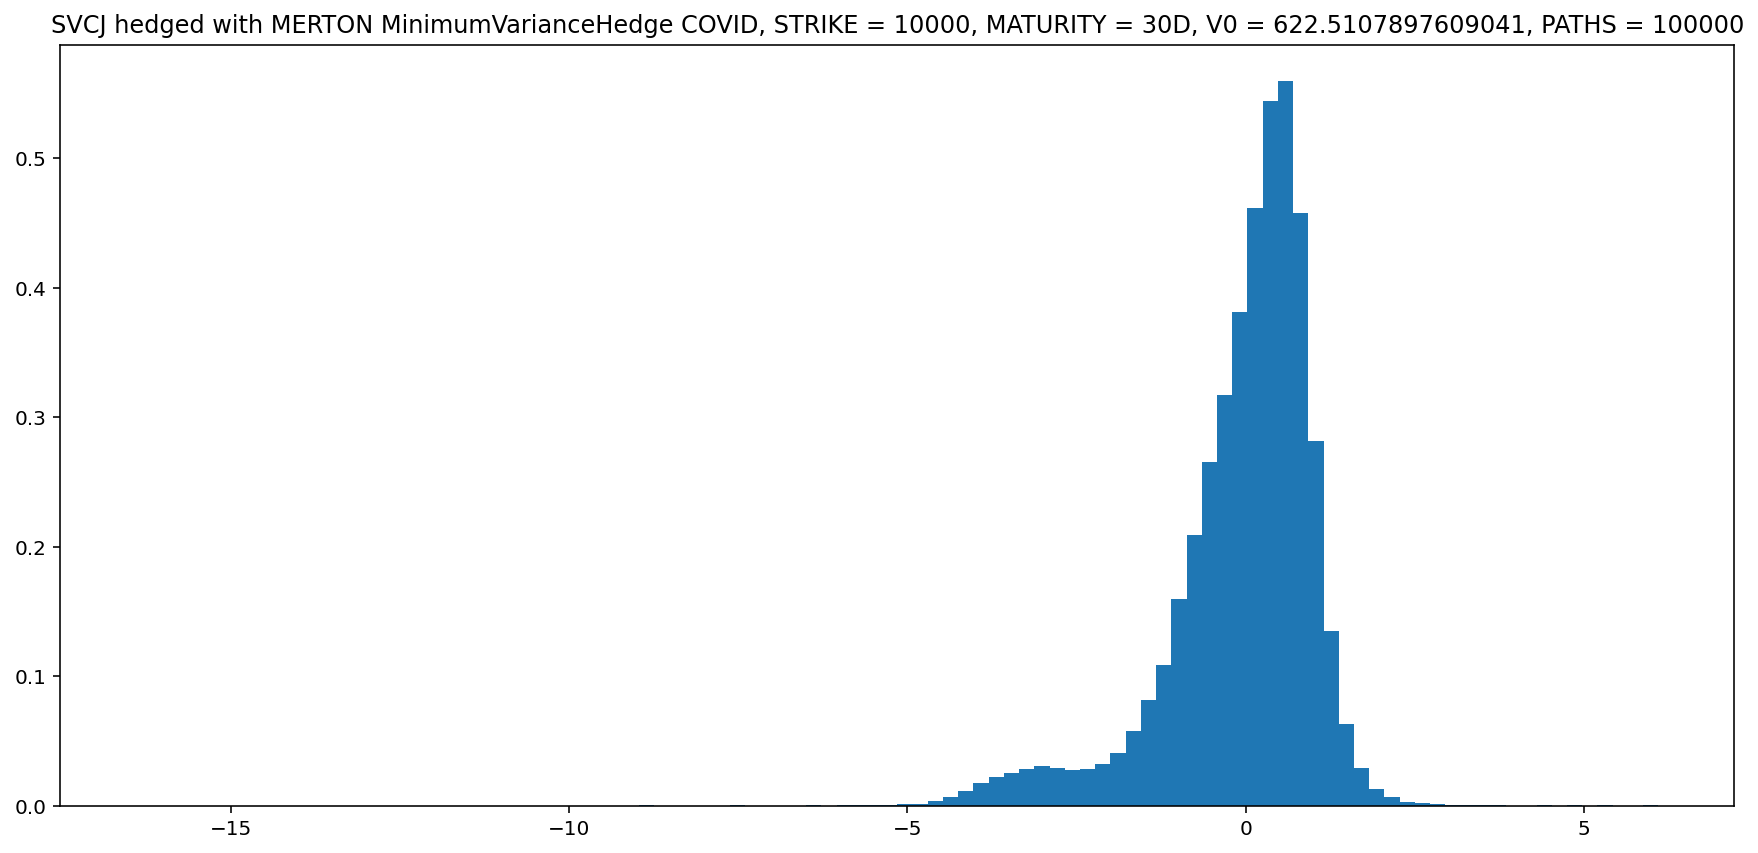

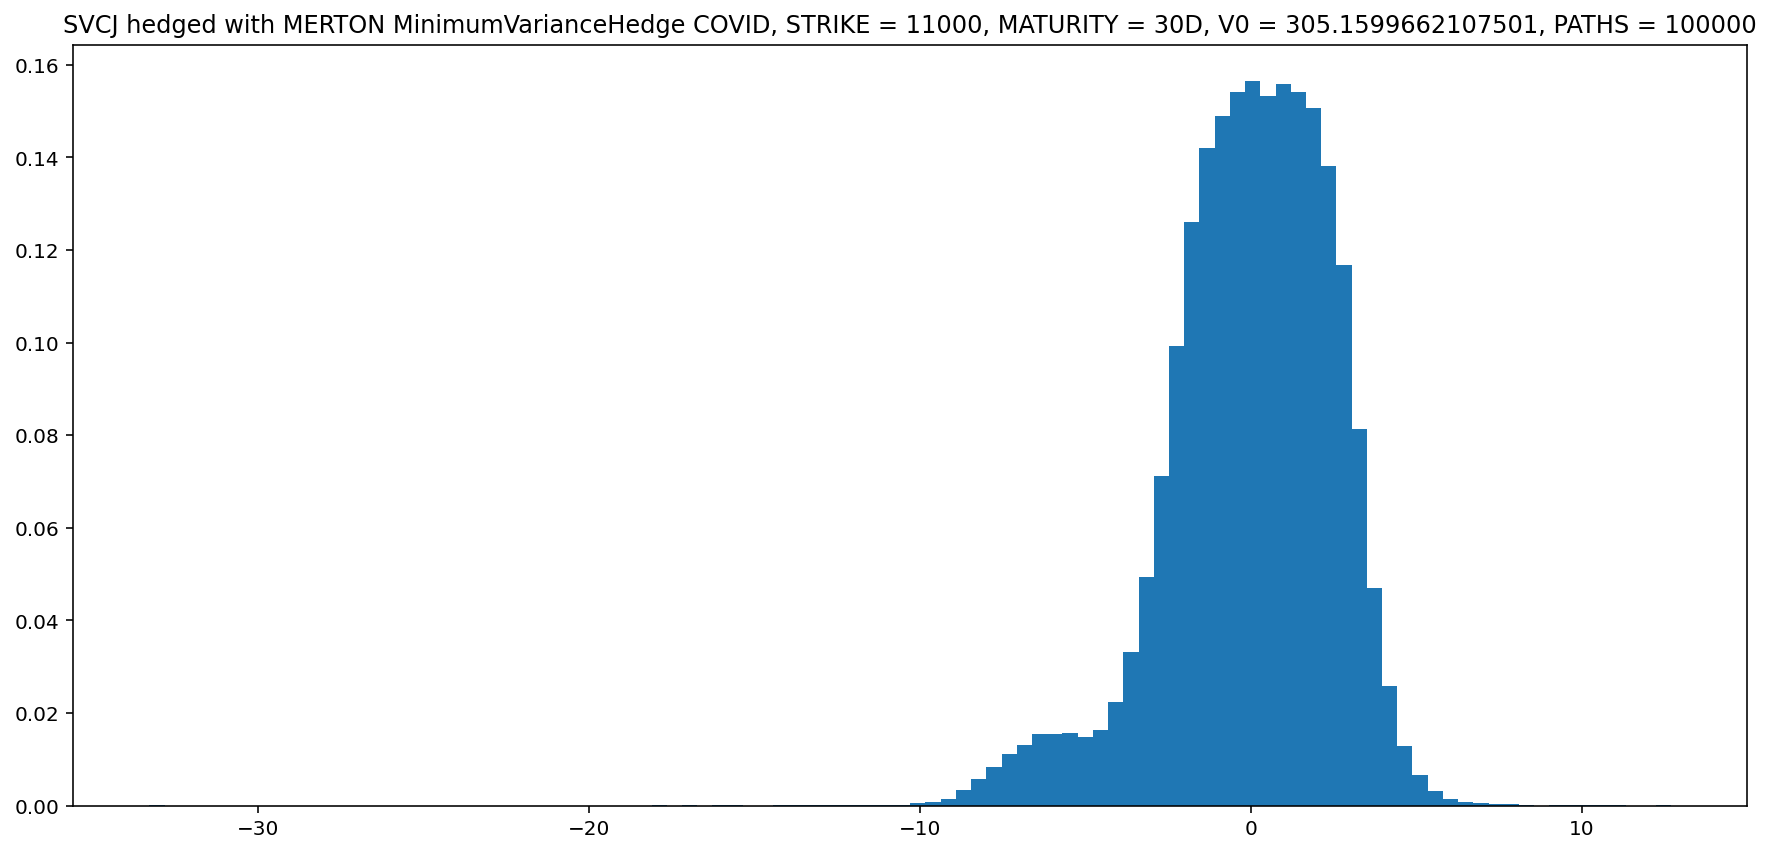

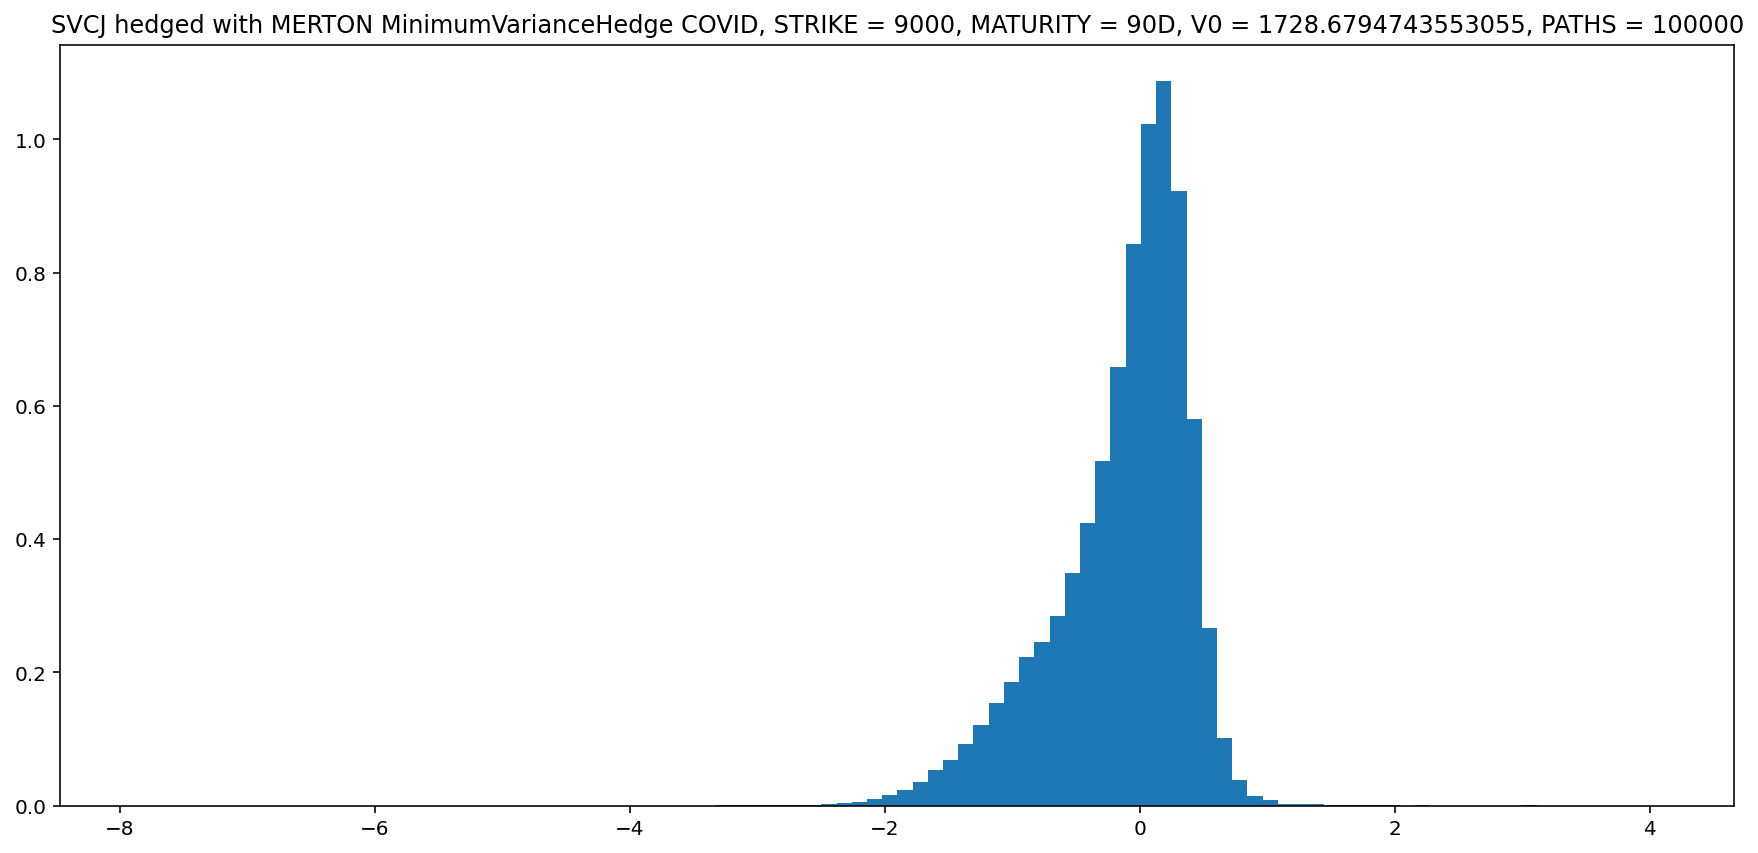

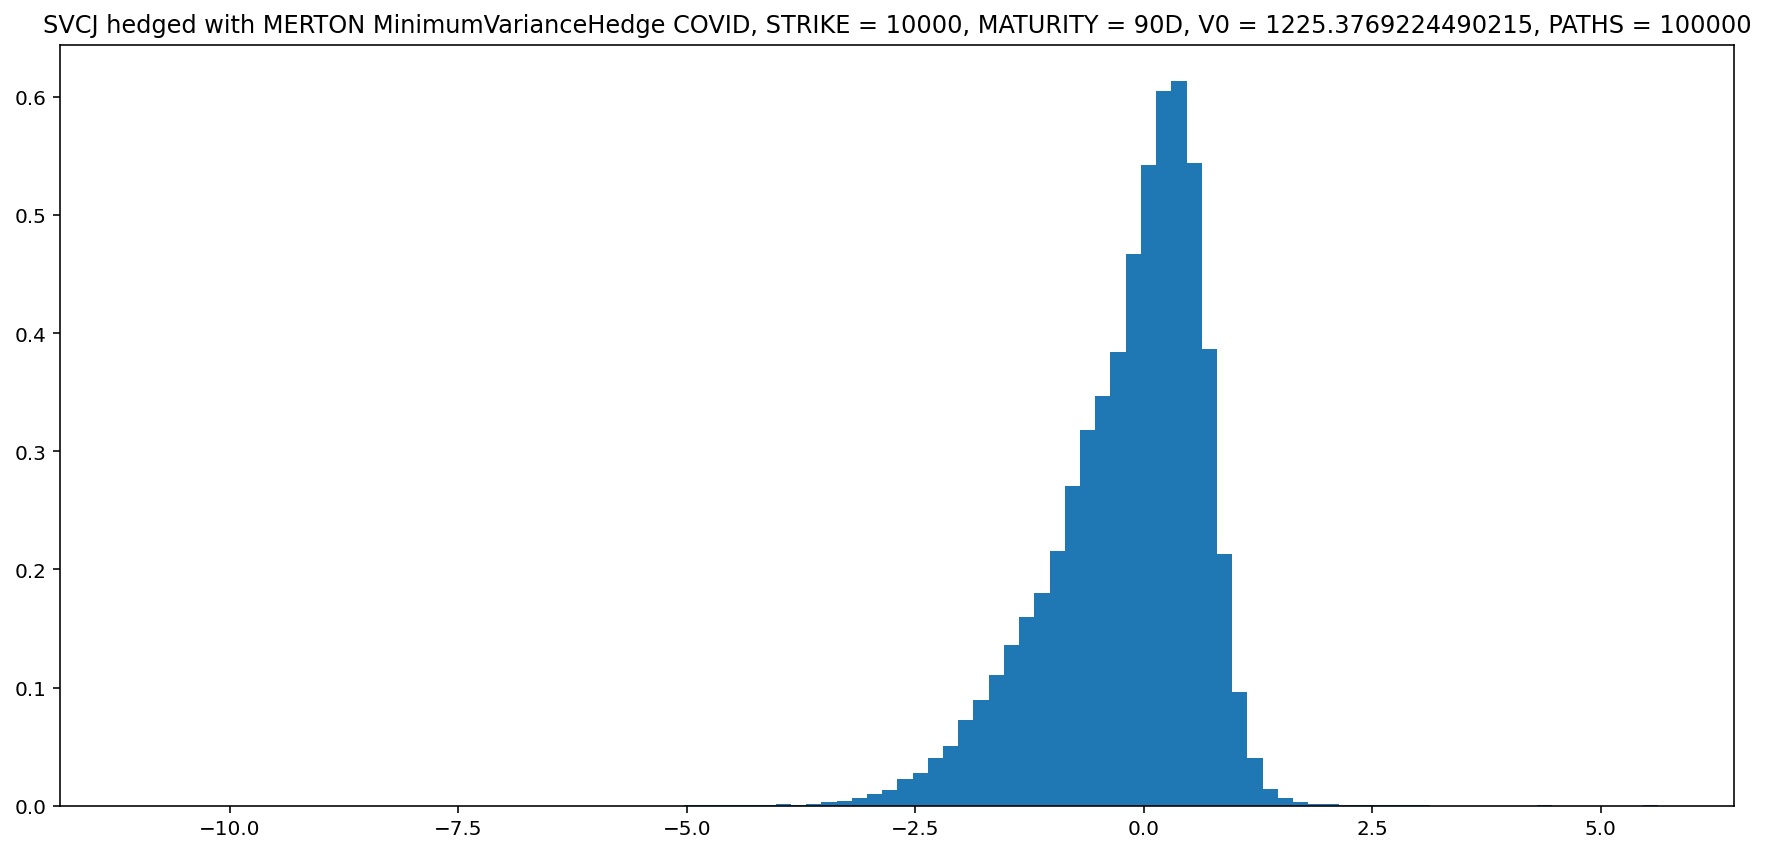

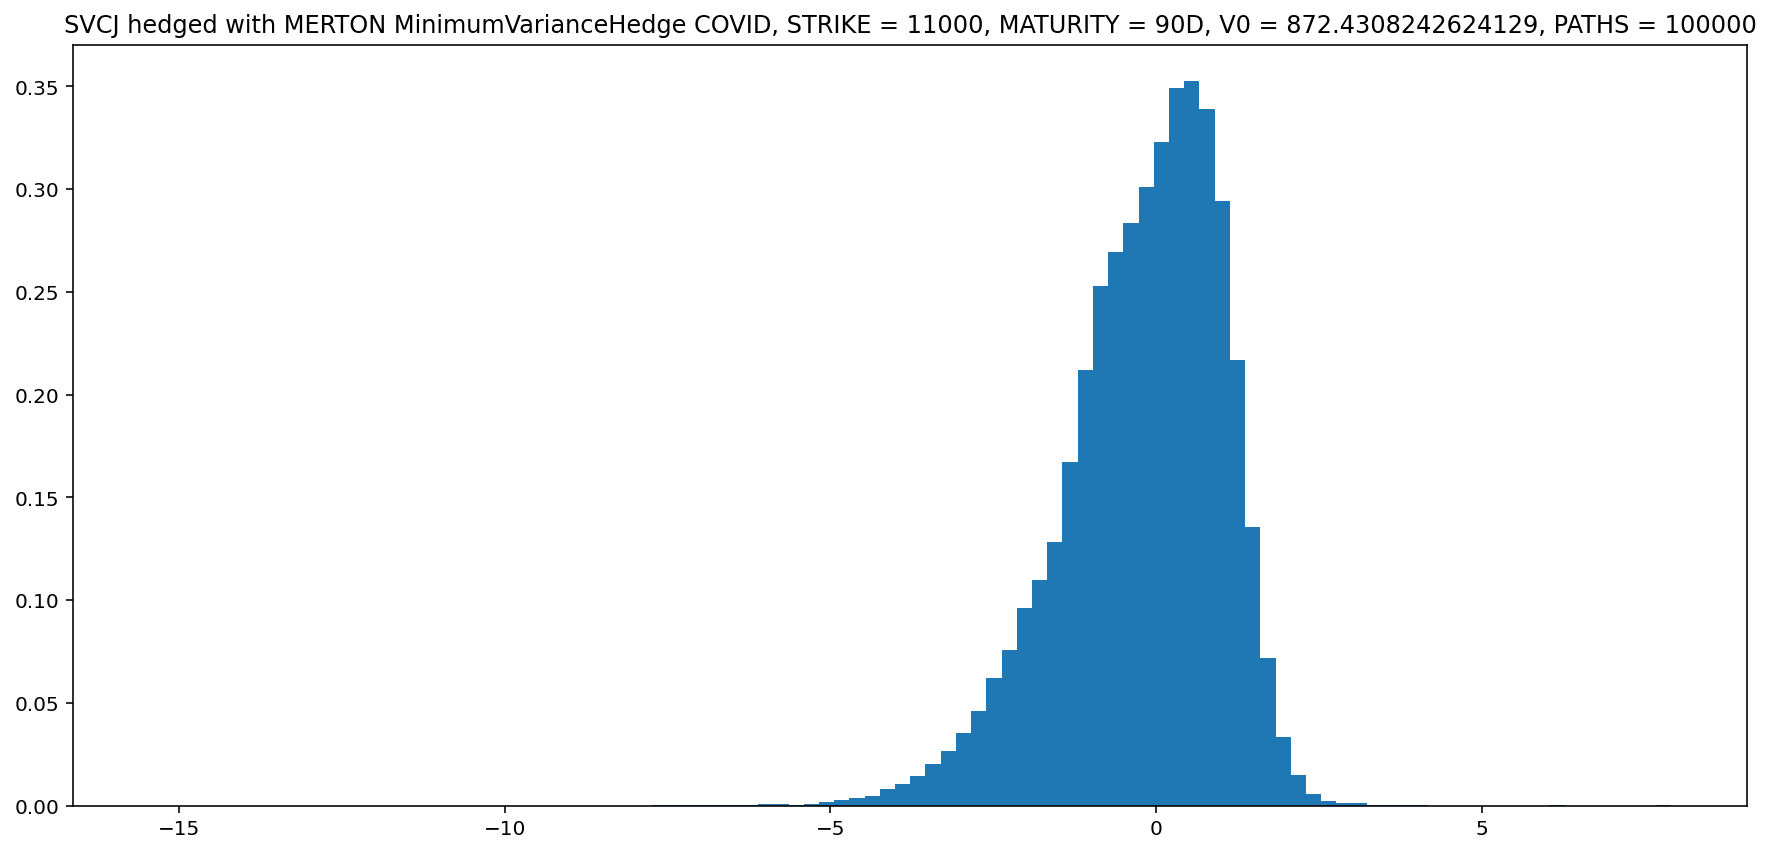

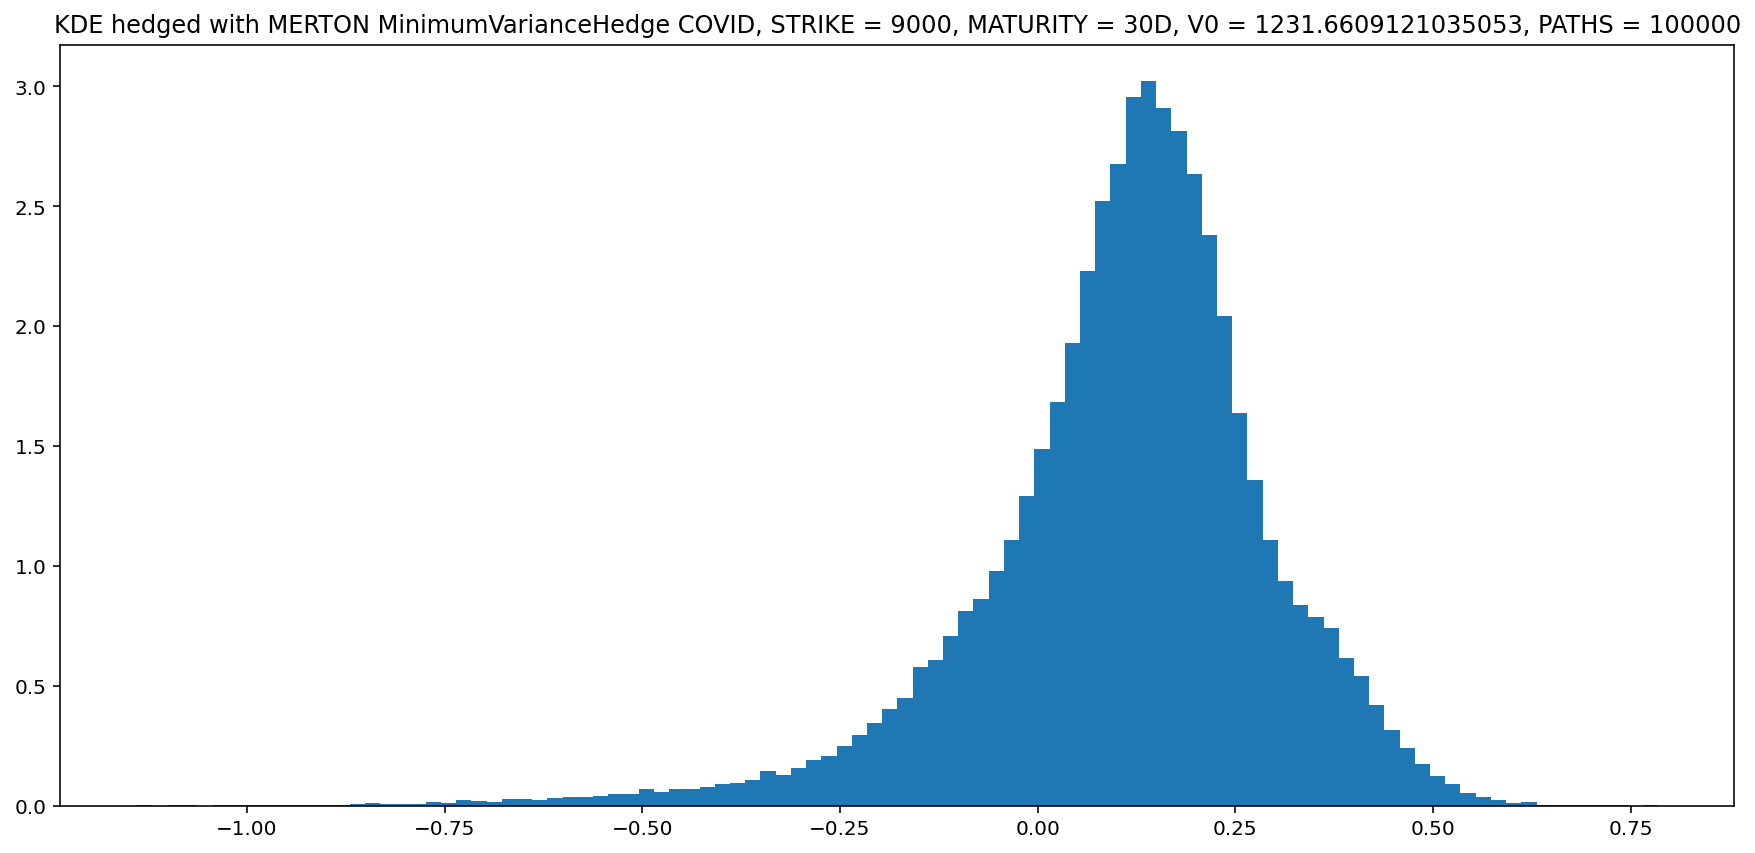

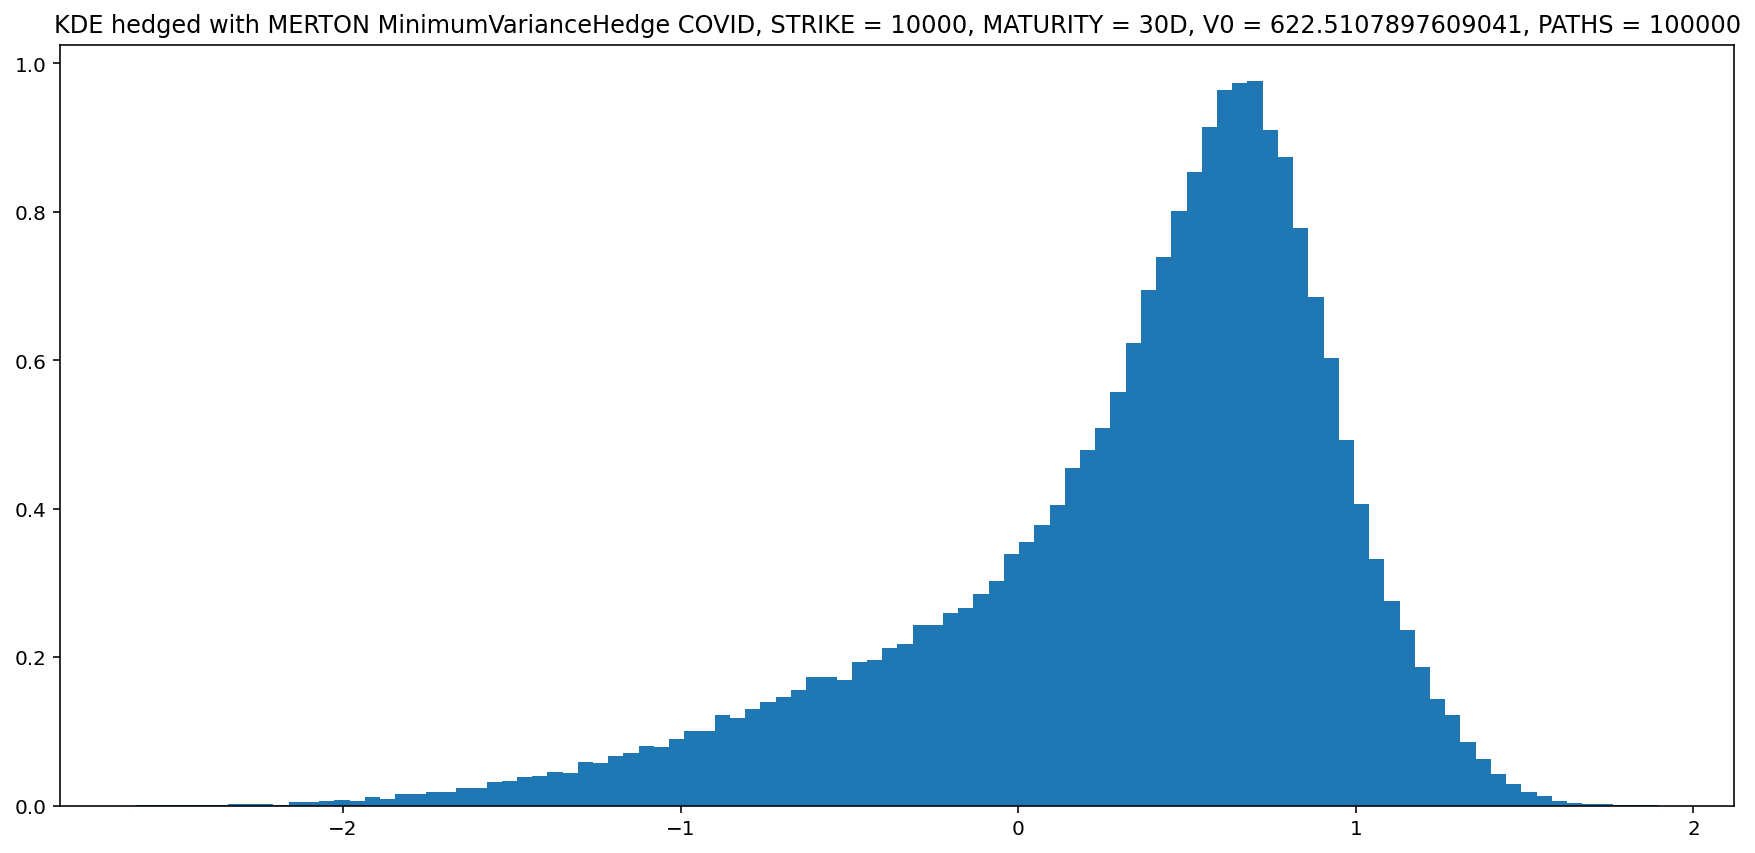

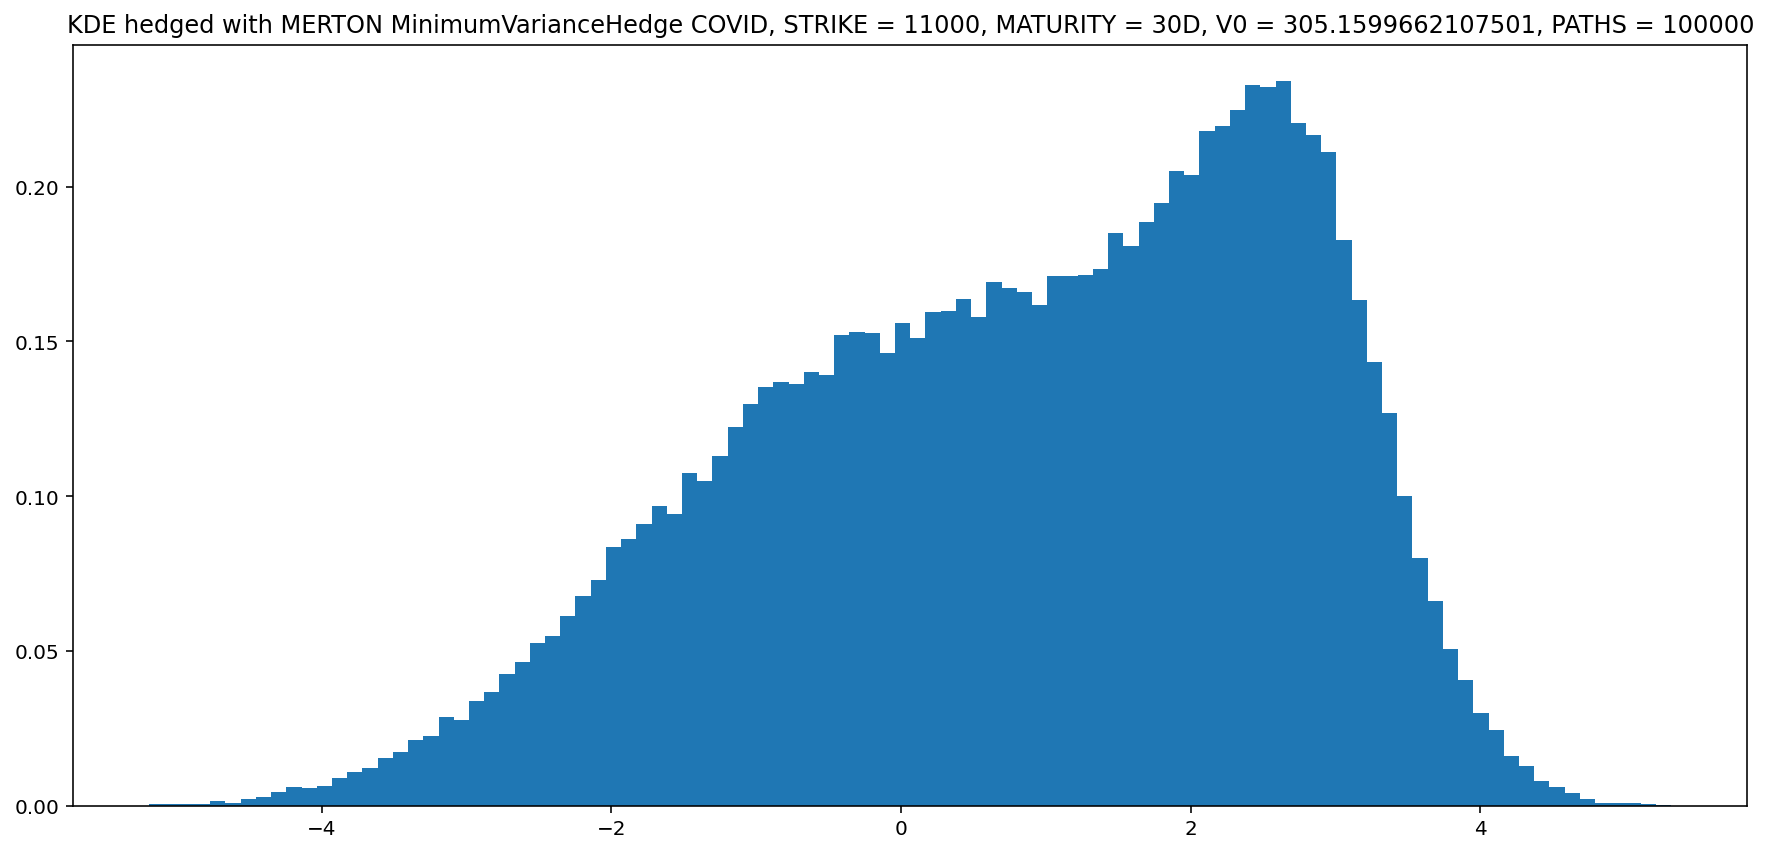

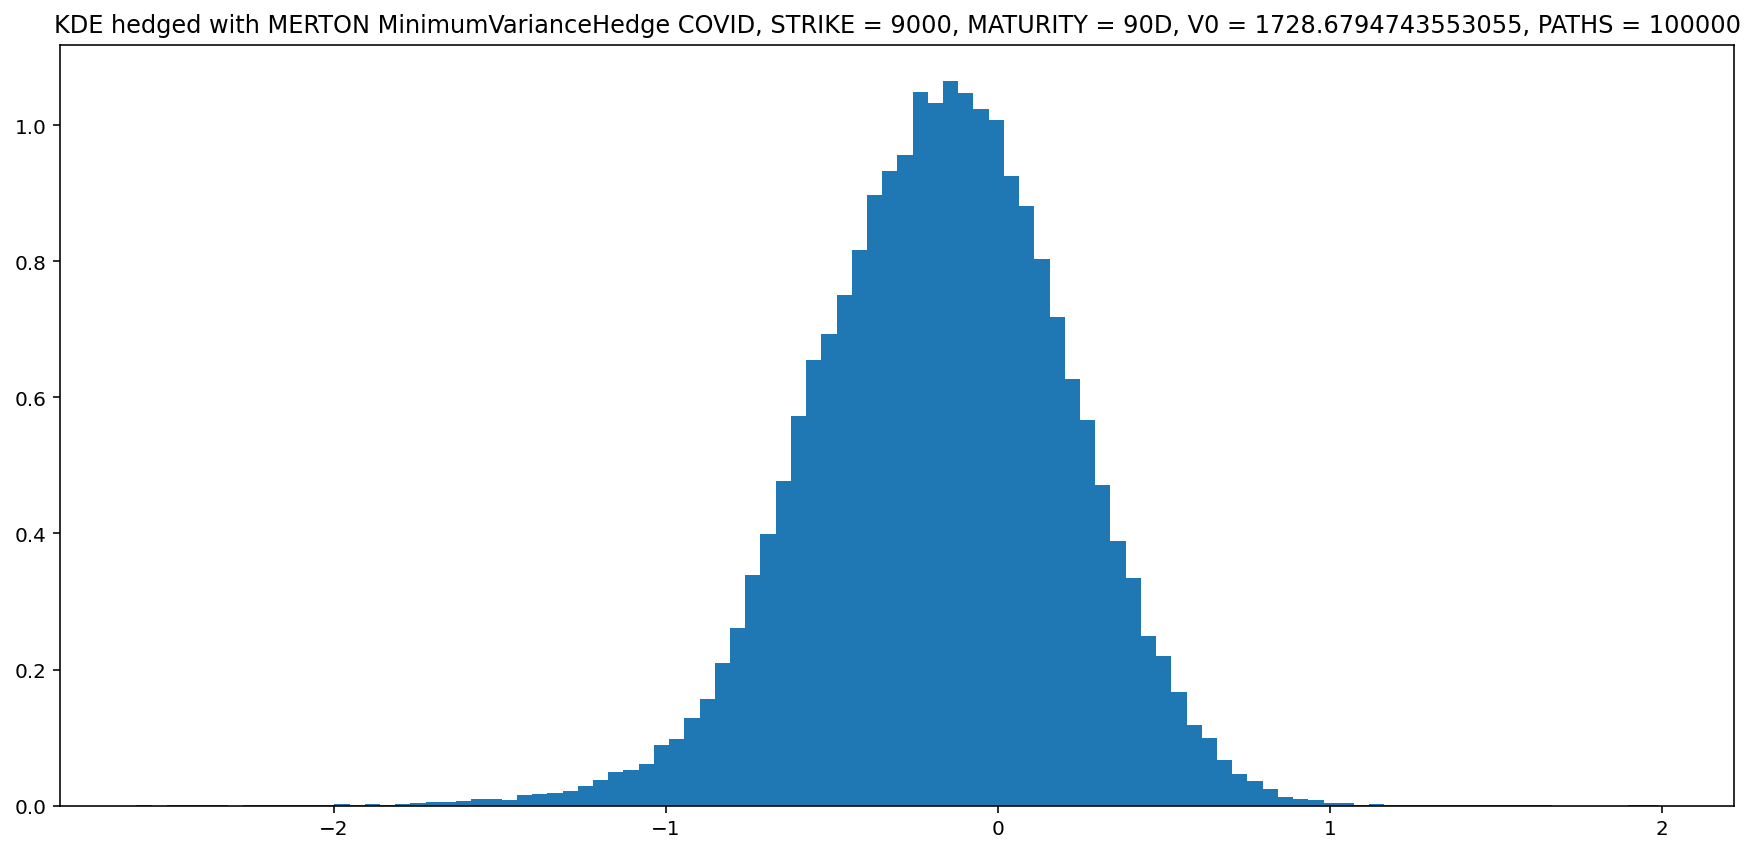

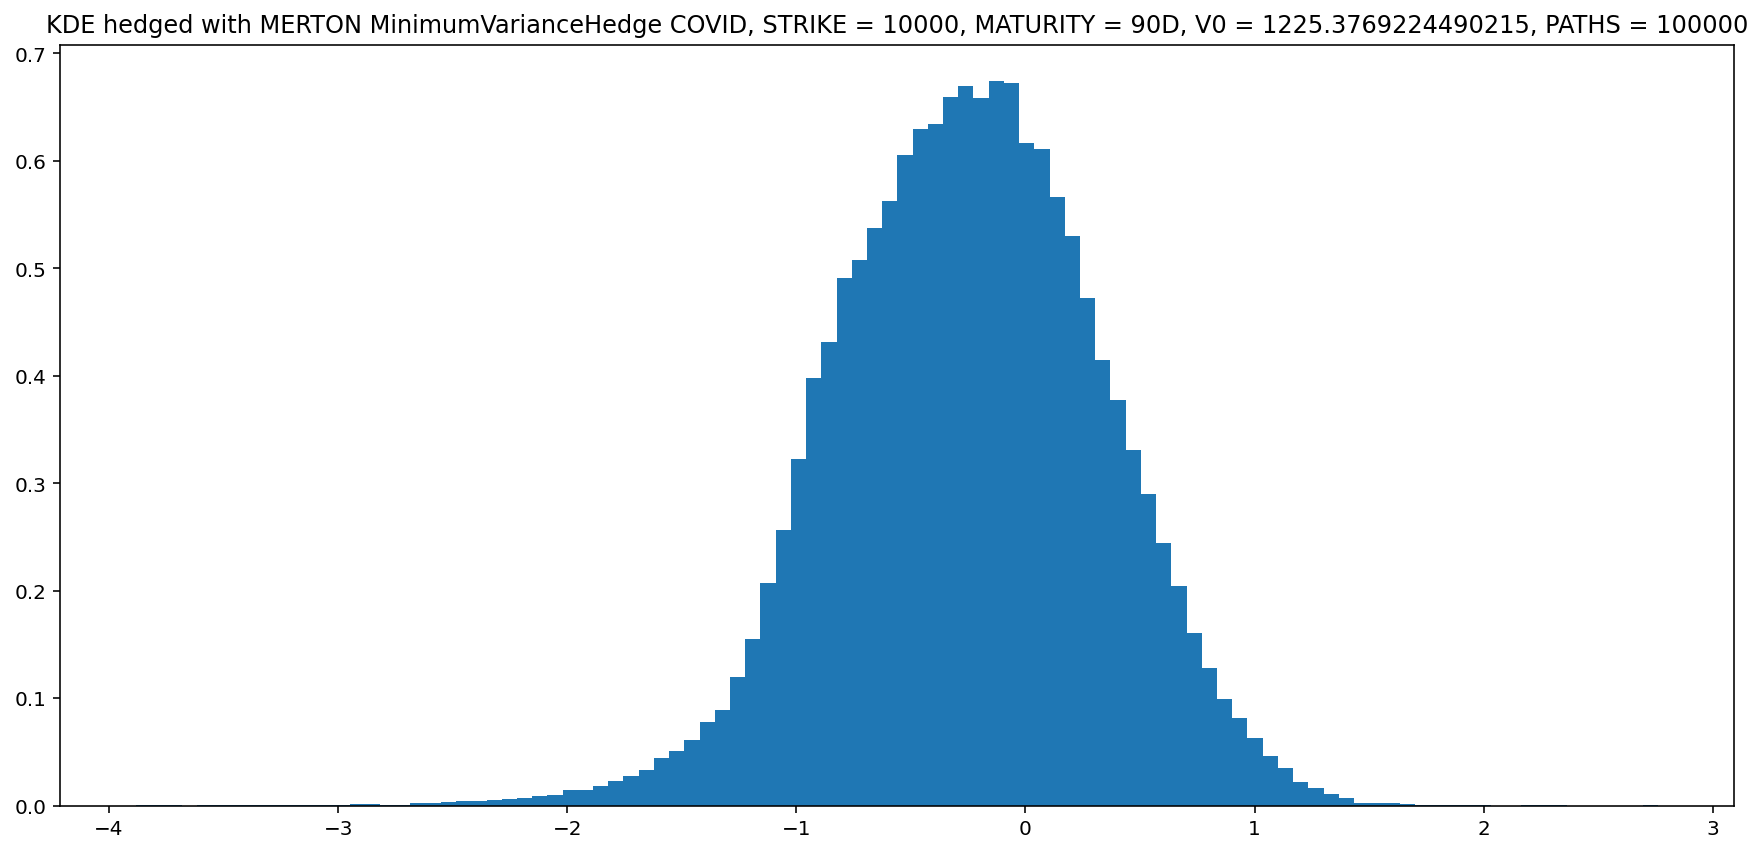

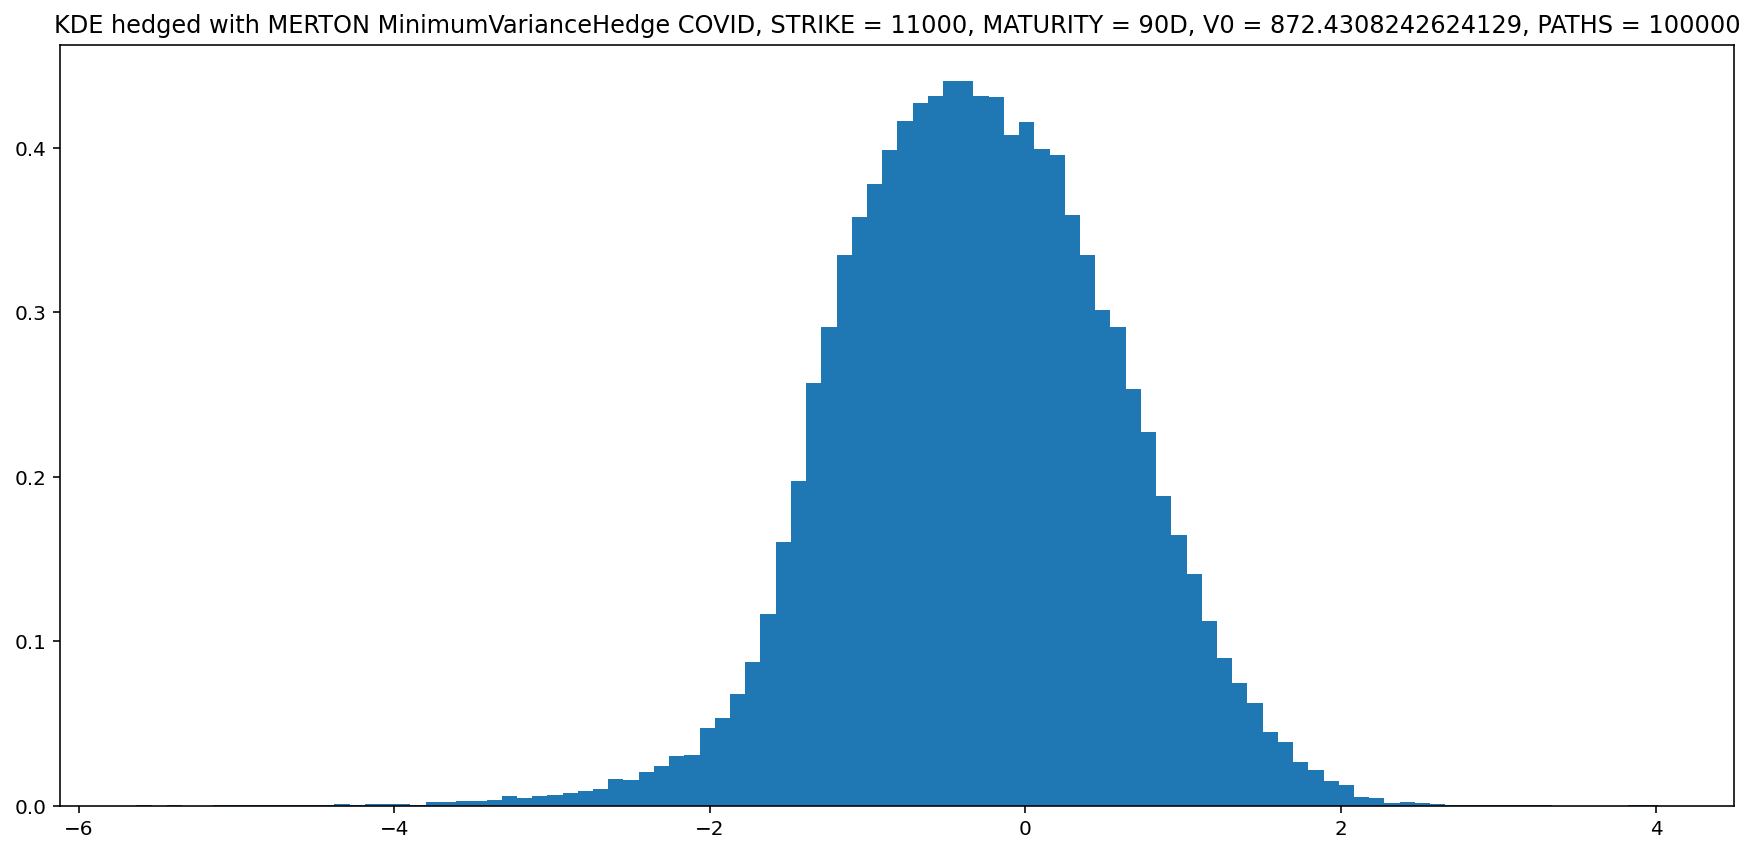

In [12]:
import multiprocess as mp

MULTIPROCESSING = False

results = []

def callback(retval):
    results.append(retval)
    progress = len(results) / len(hedges)
    print(f"\r{progress:7.2%}", end='')
    
def run(hedge):
    hedge.execute()
    
if MULTIPROCESSING:

    p = mp.Pool(mp.cpu_count())

    for hedge in hedges:
        p.apply_async(run, args=(hedge, ), callback=callback)

    p.close()
    p.join()

else:

    for hedge in hedges:
        callback(run(hedge))

# Single hedge separately

In [73]:
directory = datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")

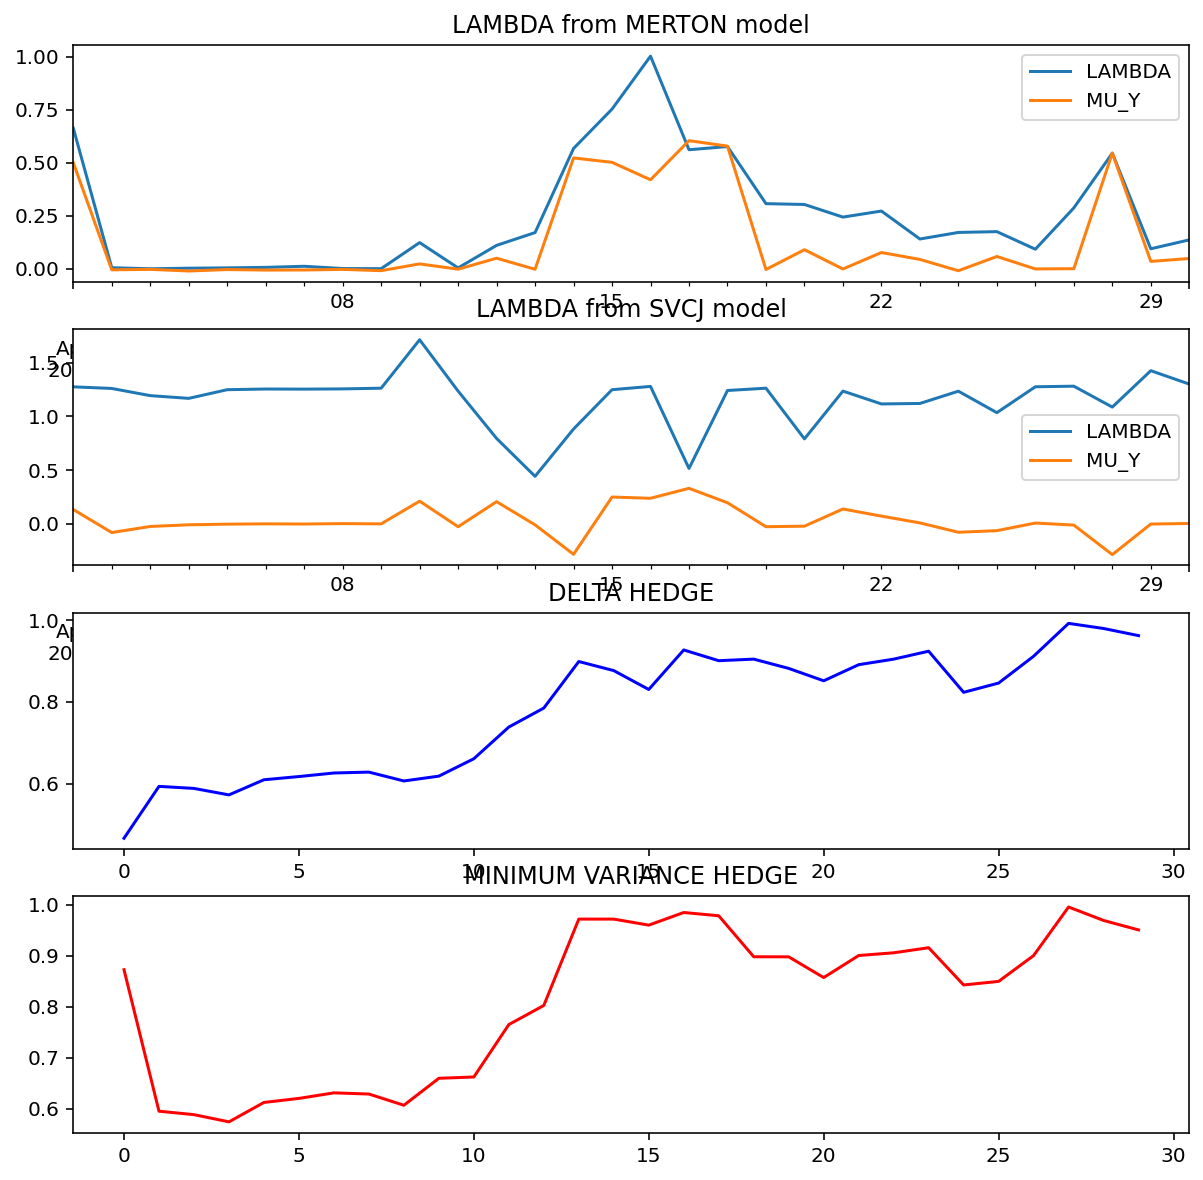

In [237]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 10))

model = MertonModel()
ax1.set_title("LAMBDA from MERTON model")
model.parameters(period.date_range)[['LAMBDA', 'MU_Y']].iloc[:30].plot(ax=ax1)

model = SVCJModel()
ax2.set_title("LAMBDA from SVCJ model")
model.parameters(period.date_range)[['LAMBDA', 'MU_Y']].iloc[:30].plot(ax=ax2)

idx = 1
ax3.set_title('DELTA HEDGE')
ax3.plot(hedges[0].strategies[0, idx, :30], c='b')

ax4.set_title('MINIMUM VARIANCE HEDGE')
ax4.plot(hedges[1].strategies[0, idx, :30], c='r')

INFO:qfin.assets.asset:Loading PATHS__SVCJ__BULLISH__SPOT__100000 paths from file.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__DeltaHedge__BULLISH__4000__30__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__DeltaHedge__BULLISH__4000__30__100000.pdf.
INFO:qfin.hedges.minimum_variance:>> Generating interpolated deltas.
INFO:qfin.hedges.minimum_variance:>> Calculating minimum variance hedge integral.
INFO:qfin.hedges.strategy:Dataframe written to _output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__4000__30__100000.csv.
INFO:qfin.hedges.strategy:Plot written to _output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__4000__30__100000.pdf.


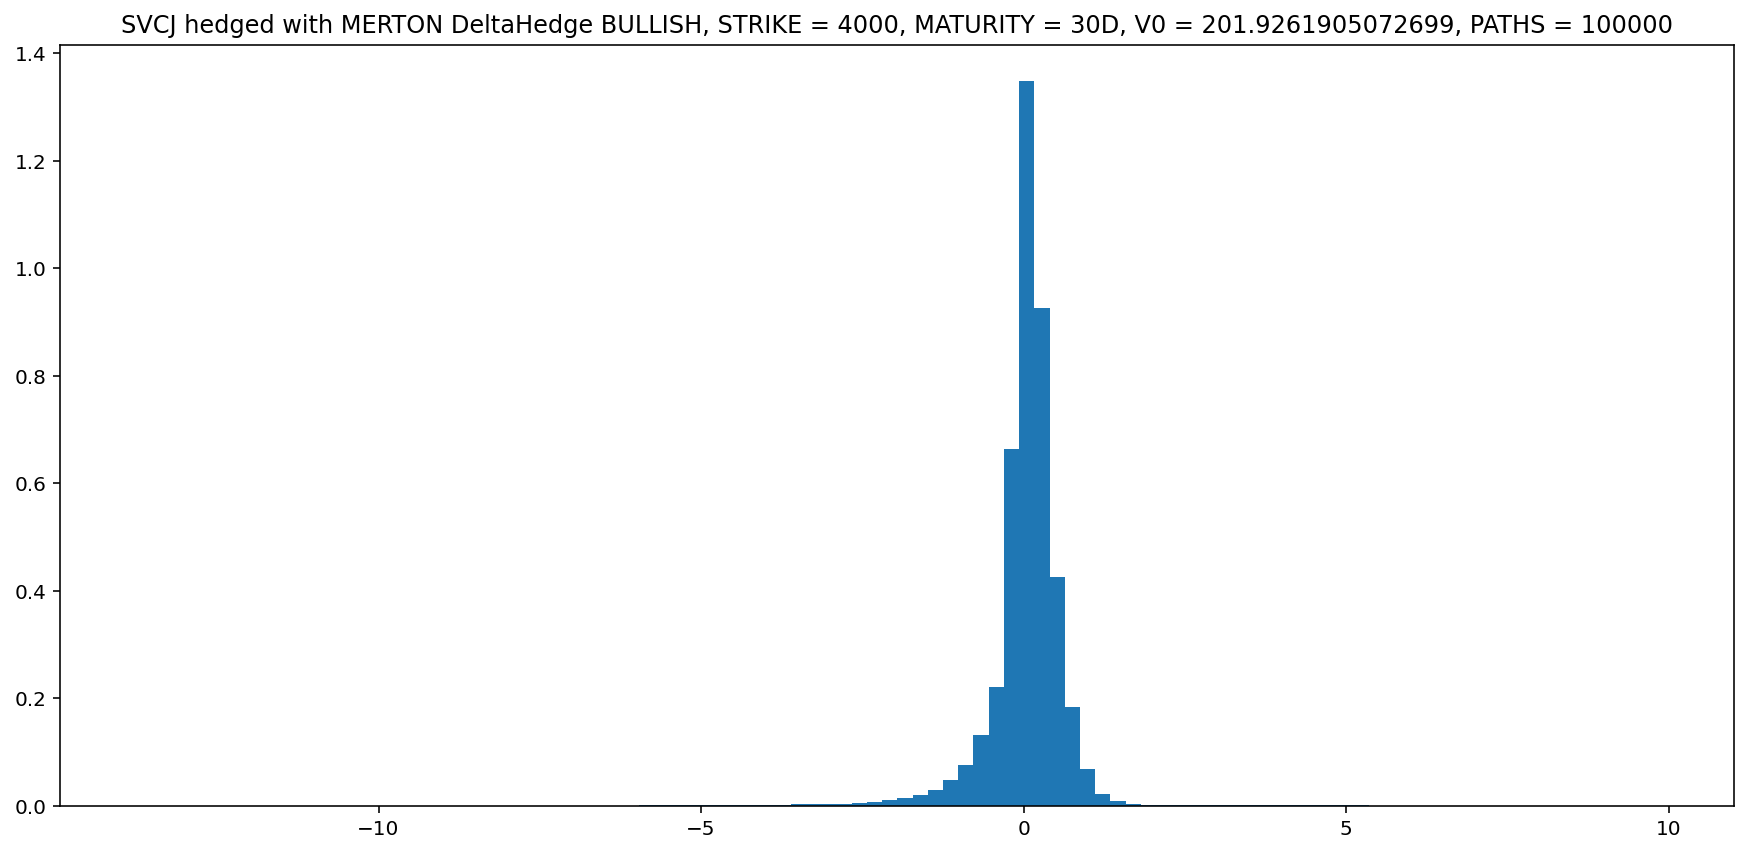

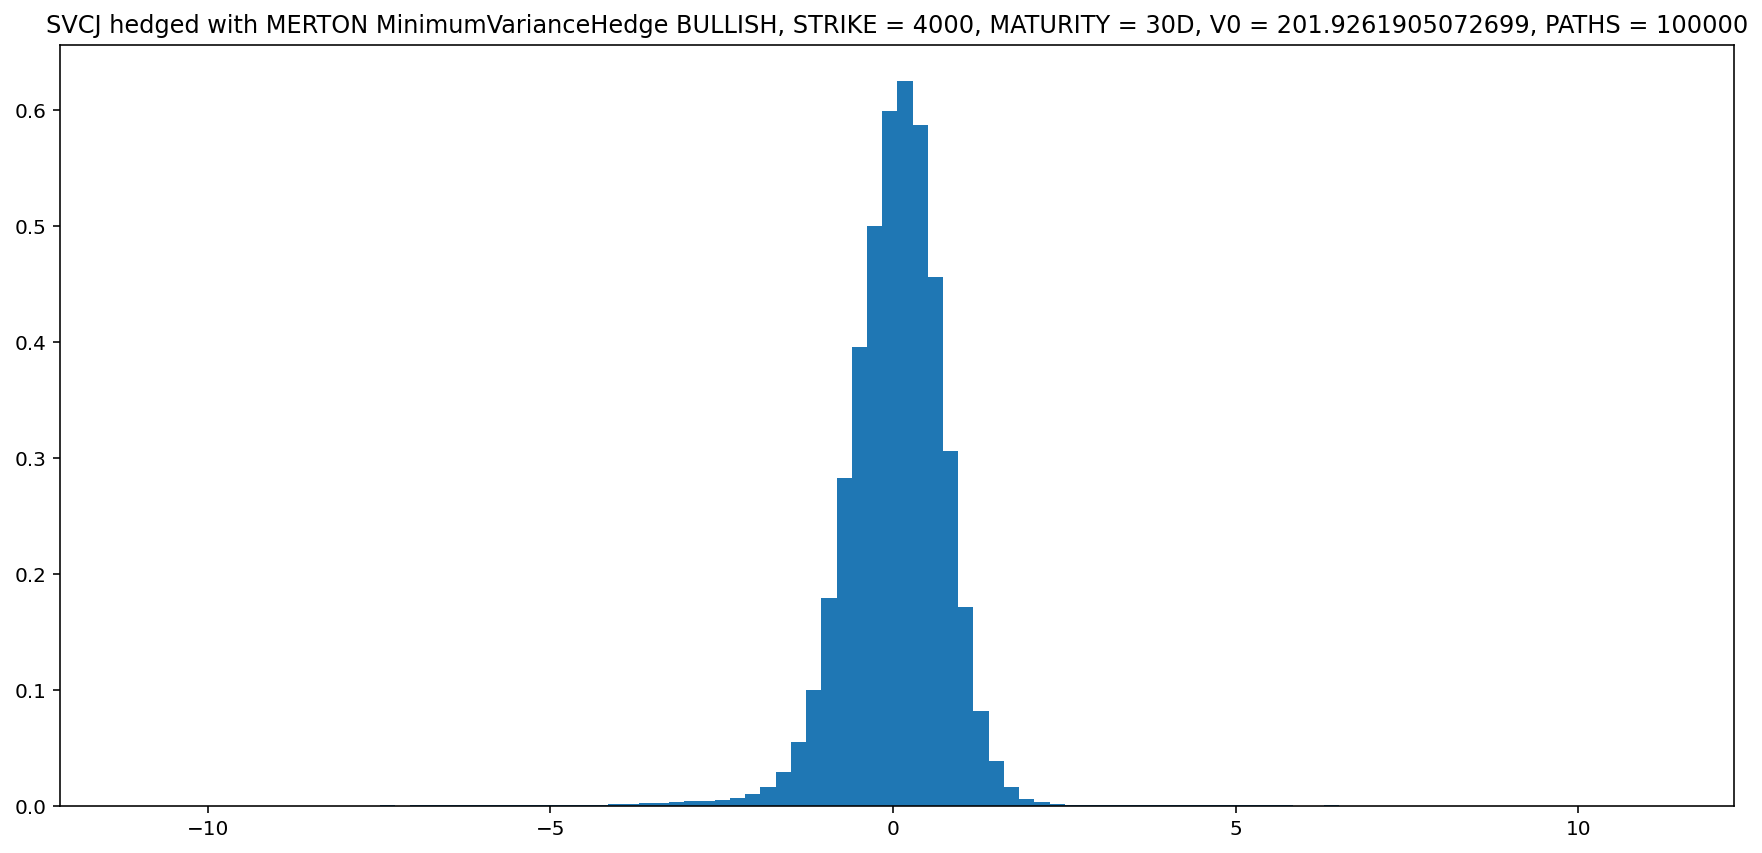

In [243]:
s0 = 4000
rate = 0.
days = 30
period = Period(t0, t1, 'BULLISH')
svcj = SVCJModel()
npaths = 10000
maturity = period.t0 + timedelta(days=days)
strike = 4000
model = MertonModel()

vs = VolatilitySurface.from_date(period.t0, svi_caching=True)
vs.calibrate()

ttm, moneyness = days/365, strike/s0
iv = vs.iv(ttm, moneyness)
v0 = bs_explicit_call(ttm, strike, s0, rate, vs.iv(ttm, strike/s0))

underlying = Spot(s0, rate, svcj, period, npaths)
underlying.init()

call = Call(underlying, maturity, strike, model, period, npaths)

hedges = [
    DeltaHedge(call, [underlying], v0, days, directory),
    MinimumVarianceHedge(call, [underlying], v0, days, directory),
]

for hedge in hedges:
    hedge.execute()

In [244]:
pnl = pd.read_csv(f'/Users/konstantinisstarovoitovs/projects/chris/_output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__DeltaHedge__BULLISH__4000__30__10000.csv', header=None)[0]
delta = np.std(pnl)

pnl = pd.read_csv(f'/Users/konstantinisstarovoitovs/projects/chris/_output/hedges/pnl/20210214_215457/PNL__SVCJ__MERTON__MinimumVarianceHedge__BULLISH__4000__30__10000.csv', header=None)[0]
mv = np.std(pnl)

delta, mv

(115.61418306135347, 148.0064348314221)

# Analyze

In [21]:
idx = np.argmin(hedge.pnl)
print(idx, hedge.pnl[idx])

2302 -62019.79831617395


In [ ]:
print("Standard error:")

for hedge in hedges:
    print(f"{hedge.name}: {np.std(hedge.pnl)}")

print("\n1 path pnl:")

for hedge in hedges:
    print(f"{hedge.name}: {hedge.pnl[idx]}")

fig, ax = plt.subplots(nrows=1 + len(hedges), figsize=(10, 1 + 4 * len(hedges)))

ax[0].set_title("ASSETS")
ax[0].plot(hedges[0].assets[0].paths[idx, :days+1], c='b')

for idy, hedge in enumerate(hedges):
    
    ax[idy+1].set_title(hedge.name)
    ax[idy+1].plot(hedge.strategies[0, idx, :], c='b')    
    
    for strategy in hedge.strategies[1:]:
        ax[idy+1].twinx().plot(strategy[idx, :], c='r')